In [19]:
%matplotlib inline
%load_ext autoreload

import warnings
warnings.filterwarnings("ignore") # disable warnings

from os import getcwd
from os.path import join, abspath, pardir, exists
import numpy as np
import pandas as pd

import pickle, json

import matplotlib.pyplot as plt
import seaborn as sns

# plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# scipy
from scipy.stats import ttest_ind, chi2_contingency, boxcox, skew
from scipy.stats.stats import pearsonr

# sklearn libraries
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.impute import KNNImputer, SimpleImputer, MissingIndicator
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_selector, make_column_transformer, make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier

# statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# IPython
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Config settings

In [95]:
parent_dir = abspath(join(join(getcwd(), pardir), pardir))
data_dir = join(parent_dir, "data")
model_dir = join(parent_dir, "models")
data_file = join(data_dir, "speed_dating.csv")

# For IPython

InteractiveShell.ast_node_interactivity = "all" # To show all output after each cell execution (instead of the last output)

# For pandas

pd.options.display.max_columns = 200 # display upto 200 columns (instead of default 20)
pd.options.display.max_rows = 200 # display upto 200 rows (instead of default 60)

#### Helper functions

In [3]:
def save_model(model, file_path: str) -> None:
    """
    Save model as a pickle file
    """
    with open(file_path, "wb") as file:
        pickle.dump(model, file)

def load_model(file_path: str):
    """
    Load model from a pickle file
    """
    with open(file_path, "rb") as file:
        return pickle.load(file)

def dataframe_to_csv(df: pd.DataFrame, file_path: str) -> None:
    """
    Save dataframe as .csv file
    """
    df.to_csv(file_path, index=False)

### Preprocessing

Data preprocessing is the first machine learning step in which we transform raw data obtained from various sources into a usable format to implement accurate machine learning models. 

In a real-world data science project, data preprocessing is one of the most important things, and it is one of the common factors of success of a model, i.e., if there is correct data preprocessing and feature engineering, that model is more likely to produce noticeably better results as compared to a model for which data is not well preprocessed.

That's why you may have heard that 80% of a data scientist’s time goes into data preprocessing and 20% of the time for model building. This isn’t false and is actually the case.

##### Typical Preprocessing Steps

Below mentioned are the typical data preprocessing steps:

- Basic checking of data: Check data types and see if you have bad data
- Refractor/Change columns names (if needed)
- Check for imbalance data
- Split your dataset into train and test datasets (stratified sampling in case of imbalance data)
- Check for missing data
- Removal of noise from the dataset
- Imputation of missing values
- Outlier detection and removal
- Feature Selection
- Create new and improved features (if needed)
- Perform new feature imputation if needed
- Normalization (transform all features' values b/w 0 & 1 )
- Standardization (transform all features so they have a mean 0 and standard deviation 1)
- Scaling the features
- Binning continuous data (if needed)
- Encoding categorical data

In [4]:
df = pd.read_csv(data_file, encoding= 'ISO-8859-1')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9

#### 1. Basic checking of data

Generally, don't tend to care about data types until we get an error or some unexpected results. However, it's better to check that data types are correctly loaded before you start your analysis. You can read more about data types in pandas [here](https://pbpython.com/pandas_dtypes.html)

In [5]:
len(df)
len(df.columns)
df.dtypes.to_frame(name='data types').T # T will represent the transpose of the resulting dataframe, better for visualization

8378

195

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
data types,int64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object,object,object,float64,float64,float64,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


##### Comment
- Seems like all the features were loaded correctly

In [6]:
display("Categorical Features")
df.describe(include='O').T 

#display("Numeric Features")
#df.describe(include='number').T 

'Categorical Features'

,count,unique,top,freq
field,8315,259,Business,521
undergra,4914,241,UC Berkeley,107
mn_sat,3133,68,"1,400.00",403
tuition,3583,115,"26,908.00",241
from,8299,269,New York,522
zipcode,7314,409,0,355
income,4279,261,"55,080.00",124
career,8289,367,Finance,202


Some features have wrong data types

In [7]:
cols_str_to_int = ['mn_sat', 'tuition', 'zipcode', 'income'] # features which needs to be converted to int
for col in cols_str_to_int:
    df[col] = df[col].fillna('0').str.replace(",","").astype(np.float).astype(int)
    # df[col] = pd.to_numeric(df[col].str.replace(",",""), errors='coerce')

Verify that data type is changed correctly

In [8]:
display("Categorical Features")
df.describe(include='O').T

'Categorical Features'

,count,unique,top,freq
field,8315,259,Business,521
undergra,4914,241,UC Berkeley,107
from,8299,269,New York,522
career,8289,367,Finance,202


#### 2. Columns renaming

It's better to rename columns (without white characters and preferably in _lower case_), so it's easier to deal with them

In [9]:
df.columns.to_frame().reset_index().T.head(1) # showing columns in a more visual way

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194
index,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3


##### Comment

- No need to change the column names since all are lower case and without any white characters.

#### 3. Split your dataset into train and test datasets

We will split our dataset into two parts: `train` & `test` datasets. We will do all the processing on the `train` dataset. `test` dataset will remain unknown to us. And we will use it only for testing analysis. This is to simulate the real world scenario in which we don't know the data which would be run on our model (after deploying)

However, there may be some issues with the `test` dataset (especially if our original dataset is bit imbalance):

1. What if few categories are missed in `test` dataset ? we won't have any hot encoding for those categories.

> One possible solution is to hot encode the new unseen categories as zero (or some default category)

> Another possible solution is to do stratified sampling (in case of imbalance data), so you have data for all the categories in both `train` and `test` datasets

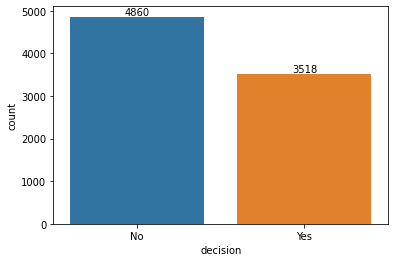

In [10]:
# df.dec.replace(0, 'No').replace(1, 'Yes').value_counts().plot(kind = 'bar')
count_ss = df.dec.replace(0, 'No').replace(1, 'Yes').value_counts() # final decision. 1 = Yes, 0 = No
ax = sns.barplot(x = count_ss.index, y = count_ss.values)
_ = ax.set(xlabel='decision', ylabel='count')
_ = ax.bar_label(ax.containers[0])

We have a sightly imbalance data (for `decision` parameter). We will be doing a stratified split for equal proprtion in `train` and `test` datasets. You can check the official doc for `train_test_split` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [11]:
# keep the random state too, so you we can reproduce the results later as well
__random_state = 0

# let's do a 85% | 15% split
train_df, test_df = train_test_split(df, test_size=0.15, shuffle=True, random_state=__random_state, stratify=df['dec'])

# reset the index for train and test
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

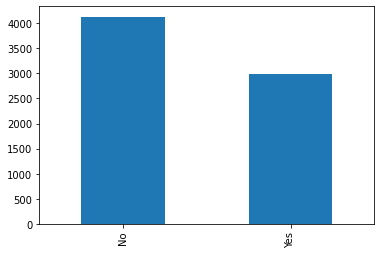

In [12]:
_ = train_df.dec.replace(0, 'No').replace(1, 'Yes').value_counts().plot(kind = 'bar')

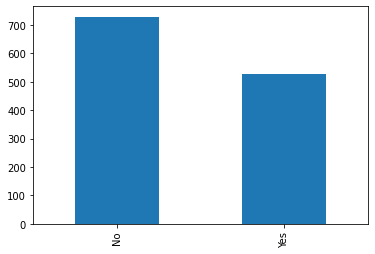

In [13]:
_ = test_df.dec.replace(0, 'No').replace(1, 'Yes').value_counts().plot(kind = 'bar')

Both `train` and `test` datasets have the same ratio of values  

In [14]:
# train_df.describe(include='all').T # check train dataset

Save the `test` dataset as a `.csv` file

In [15]:
test_file_path = join(data_dir, "test.csv")
dataframe_to_csv(test_df, test_file_path)

#### 4. Check for missing data

We need to check for missing data and imputate or remove it. It is really important to deal with all the missing data to get better EDA and less incorrect results during model training

In [16]:
# a basic first step is to check if any data is missing in predicted value
# because if some labels are not there in y_train, there isn't any point to include those rows

train_df['dec'].isnull().any()

False

So basically we are good here. Now let's see how much missing values we have for each feature

In [122]:
((train_df.isna().sum()/len(train_df)) * 100).to_frame(name='missing %').sort_values(by=['missing %'], ascending=False).T

,num_in_3,numdat_3,expnum,sinc7_2,amb7_2,shar7_2,intel7_2,fun7_2,attr7_2,amb5_3,intel5_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr5_3,sinc5_3,fun5_3,shar2_3,amb4_3,sinc2_3,intel4_3,sinc4_3,attr4_3,shar4_3,attr2_3,amb2_3,fun4_3,fun2_3,intel2_3,sinc1_3,them_cal,attr1_3,date_3,sinc3_3,fun3_3,amb3_3,fun1_3,intel1_3,intel3_3,amb1_3,shar1_3,attr3_3,you_call,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,attr1_s,sinc1_s,amb1_s,shar1_s,fun1_s,intel1_s,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,fun5_1,amb5_1,attr5_1,intel5_1,sinc5_1,undergra,intel4_2,attr4_2,sinc4_2,amb4_2,fun4_2,attr2_2,shar2_2,amb2_2,fun2_2,intel2_2,sinc2_2,shar4_2,shar4_1,amb4_1,fun4_1,intel4_1,sinc4_1,attr4_1,positin1,match_es,shar_o,shar,numdat_2,attr1_2,sinc3_2,sinc1_2,attr3_2,amb3_2,fun3_2,intel3_2,intel1_2,length,fun1_2,shar1_2,amb1_2,satis_2,amb_o,amb,met,met_o,fun_o,fun,prob_o,prob,intel_o,intel,sinc_o,sinc,like_o,like,attr_o,attr,int_corr,career_c,shar1_1,pf_o_sha,exphappy,amb1_1,intel3_1,fun3_1,sinc3_1,attr3_1,amb3_1,pf_o_amb,date,age,age_o,career,pf_o_fun,fun1_1,amb2_1,shar2_1,field_cd,pf_o_sin,pf_o_att,pf_o_int,theater,shopping,fun2_1,intel2_1,sinc2_1,attr2_1,intel1_1,sinc1_1,attr1_1,imprace,imprelig,from,yoga,tv,goal,go_out,music,reading,clubbing,movies,hiking,art,museums,gaming,dining,exercise,tvsports,sports,concerts,race,field,race_o,pid,id,dec_o,mn_sat,tuition,samerace,zipcode,match,income,partner,order,position,round,wave,condtn,idg,gender,iid
missing %,92.037635,82.207555,78.654683,76.576324,76.576324,76.393765,76.267378,76.267378,76.267378,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,76.070777,64.850442,64.850442,64.850442,64.850442,64.850442,64.850442,64.850442,64.850442,64.850442,64.850442,64.850442,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,52.773487,51.973037,51.973037,51.973037,51.973037,51.973037,50.765342,50.765342,50.765342,50.765342,50.765342,50.765342,47.746103,47.746103,47.746103,47.746103,47.746103,41.468895,41.468895,41.468895,41.468895,41.468895,41.426766,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,30.866451,22.7777,22.482797,22.482797,22.482797,22.482797,22.482797,21.949164,13.888499,12.821233,12.736975,11.276506,11.065862,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,10.883303,8.636427,8.580256,4.578009,4.563966,4.297149,4.142677,3.833731,3.777559,3.777559,3.651173,3.468614,3.440528,3.033282,2.906895,2.640079,2.485606,1.881758,1.755371,1.55877,1.474512,1.263867,1.263867,1.249824,1.249824,1.249824,1.249824,1.249824,1.249824,1.221739,1.207696,1.193653,1.137481,1.137481,1.123438,1.123438,1.123438,1.053223,1.025137,1.025137,1.025137,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.997051,0.800449,0.800449,0.800449,0.14043,0.014043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Okay! so we have lots of columns with missing values (_as also already shown in EDA too_). Let's see what are the typical ways to deal with them

There are multiple ways to compute the missing values. Although most of them are `distance based` and only work on _numeric_ features. Missing values are computed on training data only otherwise it can cause _Data Leakage_ (accidentally share the information between the `test` and `train` datasets) as well. List below are the typical ways we use to deal with missing values:

1. Check manually what values are missing and correct them. We can check if there is a pattern to the missing values, think about the possible reasons why it happened in the first place

2. Also, it is know practice to drop the columns if they have more than ~50% of the missing values

3. Deleting rows with missing values - Deleting rows (if we have enough data) or column (if column is not important intutive idea from domain knowledge)

4. Impute missing values for continuous variable - mean/median - without causing _data leakage_

5. Impute missing values for categorical variable - mode ('most_frequent' or 'constant' strategy)

6. Other Imputation Methods - interpolation (provide missing term using nearby trends, newton forward/backward formula, for multivariate - nearest neighbour interpolation, gaussian, polynomial (good for time series interpolation))

7. Using Algorithms that support missing values (k-NN - based on k, get the closest rows using euclidean distance and take the average of there missing value column values)

> Note: Imputation: Replace missing datas with statistical values. sklearn has a [`Imputation` module (sklearn.impute)](https://scikit-learn.org/stable/modules/impute.html#impute) which is quite helpful here.

#### How to impute the missing data ? What do we need ?

- A generalized model for missing values so that if values are missing in test data the model will not break
- Although the mordern tree based algorithms manages the missing values by default using techniques such as `fragments` and `surrogate splits` so while using these algos we do not need to worry about missing values
- We can make a gernalized imputation model which can deal with all the unexpected missing values if required

---

#### Some of the imputers being used from [_sklearn.impute_](https://scikit-learn.org/stable/modules/impute.html#impute) module

##### [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)

- Replace `NaN` (`np.nan`) by the `mean`, `median`, `most_frequent` or `constant`


##### [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer)

- Replace your missing values by closest ones
- Imputation for completing missing values using k-Nearest Neighbors
- Each sample’s missing values are imputed using the _mean_ value from `n_neighbors` nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close

##### [MissingIndicator](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator)

- Position of missing values by a `boolean` mask

In [47]:
# threshold for missing value - remove all columns which has greater than 50% of missing values
__missing_threshold = float(50)

missing_df = ((train_df.isna().sum()/len(train_df)) * 100).to_frame(name='missing').sort_values(by=['missing'], ascending=False).query("missing > {}".format(__missing_threshold))
missing_cols = missing_df.index.to_list()

In [112]:
# imputate missing values
def imputate_missing_features(data, missing_threshold = 50):
    """
    Method to imputate missing values and return a imputate model
    """

    # threshold for missing value - remove all columns which has greater than 50% of missing values
    __missing_threshold = missing_threshold

    missing_df = ((data.isna().sum()/len(data)) * 100).to_frame(name='missing').sort_values(by=['missing'], ascending=False).query("missing > {}".format(__missing_threshold))
    missing_cols = missing_df.index.to_list()

    cols_to_use = list(set(data.columns.to_list()) - set(missing_cols))
    cols_to_use = [x for x in cols_to_use if x != 'dec']
    
    #X, y = data[cols_to_use], data['dec']
    X, y = data, data['dec']
    X.drop(['dec'], axis=1, inplace=True)

    num_features = make_column_selector(dtype_include=np.number) # get all numeric data
    cat_features = make_column_selector(dtype_exclude=np.number)

    imputate_pipeline = make_column_transformer(
        (SimpleImputer(strategy='mean'), num_features),
        (MissingIndicator(missing_values=np.nan, features="all", error_on_new=False), num_features),

        remainder="drop", # drop the remaining columns
        n_jobs=-1, # run jobs using all available processors (for speedup computation)
    )

    num_pipe = make_pipeline(
        KNNImputer(n_neighbors=5, add_indicator=True),    # stack MissingIndicator on the output
        #imputate_pipeline,
        StandardScaler()
    )

    cat_pipe = make_pipeline(
        SimpleImputer(strategy = 'most_frequent'),
        OneHotEncoder(handle_unknown='ignore', sparse=False)
    )

    col_trans = make_column_transformer(
        (num_pipe, num_features),
        (cat_pipe, cat_features)
    )

    col_trans.fit(X)

    return X, cols_to_use, col_trans

In [113]:
X, cols_to_use, col_trans = imputate_missing_features(train_df)

Save the imputated model as pickle (`.pkl`) file

In [114]:
save_model(col_trans, join(model_dir, "col_trans.pkl"))

Imputate the `train` dataset

In [120]:
train_df.shape
train_df = X
train_df.shape

(7121, 194)

(7121, 194)

In [ ]:
# train_df.isnull().any() # check missing values now

#### 5. Check for outliers

In order to check outliers in your dataset, there are various methods worth looking into:

1. _Box plots_
2. _Z-score test (normal distribution assumption)_
3. _Model based (One class SVM, density based algorithams, etc)_

Some useful resources:

- [Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html)
- [Ways to Detect and Remove the Outliers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

> For our use case, we will be checking outliers with _box plots_ and _density based algoritham_ (`DBSCAN`)

##### Box Plots

In [ ]:
def draw_box_plots(df, cols):
    """
    Draw Box Plot & Histogram for each column
    """
    for col in cols:
        fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
        _ = df.boxplot(column=col,ax=axes[0]);
        _ = df.hist(column=col, ax=axes[1]);

(7121, 190)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field_cd,mn_sat,tuition,race,imprace,imprelig,zipcode,income,goal,date,go_out,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,477,12.0,0,23,2,19,15,4,4.0,11,14,494.0,0,0.29,0,30.0,2.0,25.00,25.00,25.00,25.00,0.00,0.00,0,6.0,8.0,8.0,7.0,7.0,5.0,5.0,5.0,2.0,27.0,5.0,0,0,3.0,5.0,7.0,0,0,1.0,4.0,2.0,5.0,9.0,6.0,7.0,8.0,6.0,8.0,8.0,4.0,7.0,7.0,4.0,7.0,8.0,7.0,7.0,6.0,4.0,7.0,NaN,16.00,19.00,16.00,17.00,15.00,17.00,20.0,20.0,15.0,15.0,15.0,15.0,25.00,20.00,15.00,20.00,10.00,10.00,6.0,8.0,7.0,7.0,7.0,6.0,7.0,7.0,6.0,8.0,7.0,6.0,7.0,7.0,7.0,NaN,6.0,5.0,0.0,3.0,8.00,8.00,6.0,8.00,7.0,6.00,6.0,8.0,7.0,7.0,7.0,8.0,1.0,3.0,20.0,19.0,15.0,19.0,16.0,11.0,18.00,19.00,15.0,17.00,15.0,16.00,20.0,18.0,17.0,17.0,14.0,14.0,21.00,17.00,15.00,19.00,12.00,16.00,6.0,8.0,6.0,6.0,7.0,7.0,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,382,4.0,0,7,2,15,19,17,17.0,2,13,409.0,0,-0.30,1,23.0,2.0,20.00,15.00,20.00,20.00,10.00,15.00,0,3.0,6.0,7.0,4.0,7.0,2.0,3.0,4.0,2.0,28.0,14.0,0,0,2.0,8.0,1.0,10028,52010,2.0,7.0,3.0,6.0,6.0,5.0,10.0,10.0,9.0,9.0,6.0,8.0,3.0,8.0,10.0,8.0,10.0,9.0,9.0,9.0,1.0,6.0,NaN,25.00,25.00,25.00,10.00,10.00,5.00,80.0,0.0,10.0,10.0,0.0,0.0,80.00,0.00,10.00,10.00,0.00,0.00,7.0,7.0,7.0,7.0,10.0,8.0,8.0,8.0,8.0,8.0,6.0,8.0,8.0,8.0,6.0,8.0,6.0,5.0,2.0,3.0,20.00,20.00,20.0,20.00,10.0,10.00,6.0,7.0,7.0,8.0,9.0,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,20.00,20.00,20.0,20.00,10.0,10.00,20.0,20.0,20.0,20.0,10.0,10.0,60.00,5.00,5.00,10.00,10.00,10.00,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,395,17.0,0,33,2,15,19,11,11.0,11,15,411.0,0,0.46,1,34.0,2.0,35.00,15.00,15.00,25.00,10.00,0.00,0,8.0,10.0,10.0,8.0,9.0,5.0,5.0,4.0,2.0,33.0,6.0,0,14388,2.0,1.0,2.0,16803,33906,3.0,4.0,2.0,6.0,3.0,4.0,4.0,10.0,8.0,8.0,6.0,1.0,8.0,9.0,3.0,10.0,10.0,7.0,9.0,7.0,8.0,4.0,NaN,20.00,20.00,20.00,10.00,10.00,20.00,30.0,20.0,10.0,20.0,10.0,10.0,30.00,20.00,10.00,20.00,10.00,10.00,8.0,8.0,7.0,9.0,7.0,9.0,8.0,8.0,7.0,8.0,7.0,8.0,9.0,7.0,NaN,8.0,7.0,7.0,2.0,5.0,30.00,15.00,20.0,10.00,15.0,10.00,9.0,10.0,8.0,8.0,7.0,5.0,3.0,2.0,50.0,10.0,10.0,20.0,5.0,5.0,30.00,15.00,20.0,15.00,10.0,10.00,40.0,10.0,10.0,20.0,10.0,10.0,50.00,5.00,5.00,20.00,5.00,15.00,9.0,10.0,9.0,8.0,8.0,8.0,10.0,9.0,8.0,7.0,0.0,1.0,0.0,NaN,NaN,40.0,10.00,25.00,10.00,10.00,5.00,50.0,15.0,15.0,20.0,0.0,0.0,50.0,10.0,10.0,20.0,10.0,0.0,60.0,0.0,10.0,25.0,0.0,5.0,9.0,10.0,9.0,9.0,7.0,8.0,9.0,8.0,9.0,7.0
3,153,12.0,0,23,2,7,16,11,11.0,14,5,162.0,0,0.30,1,27.0,4.0,15.22,1

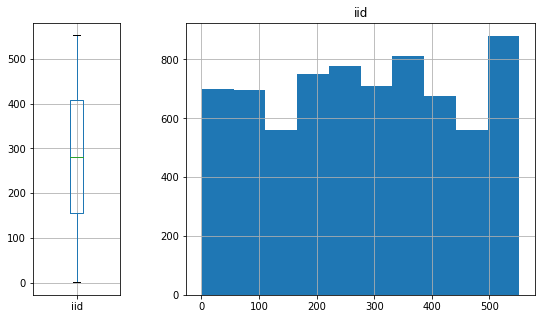

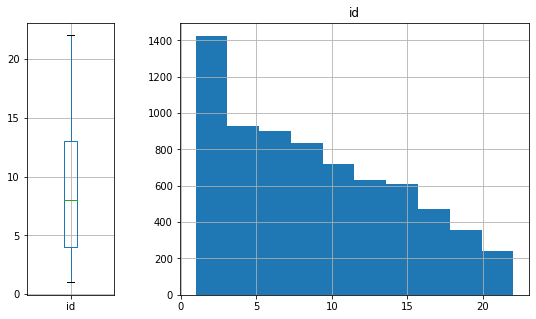

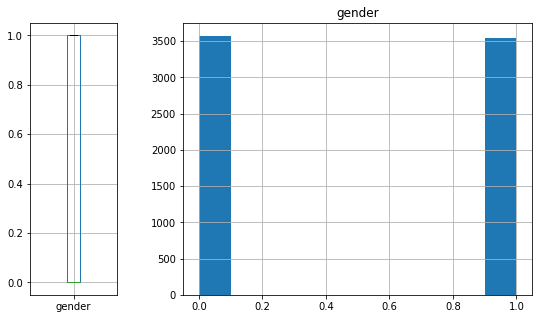

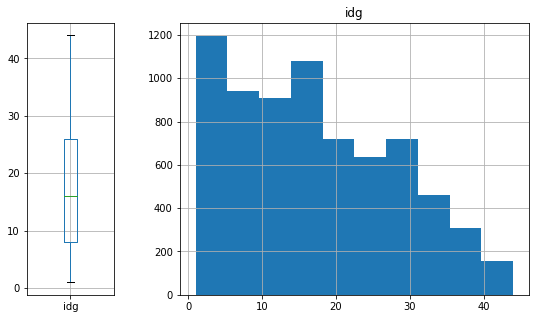

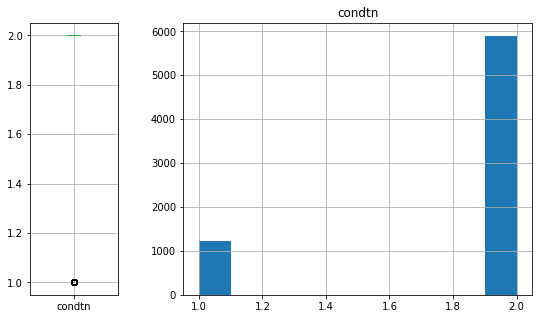

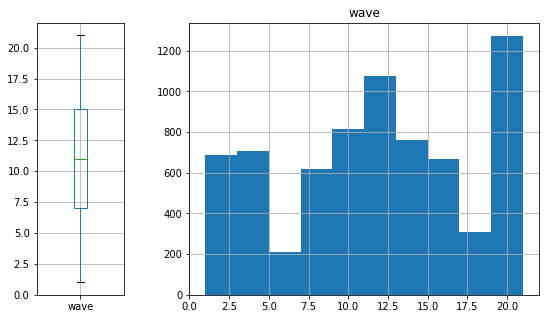

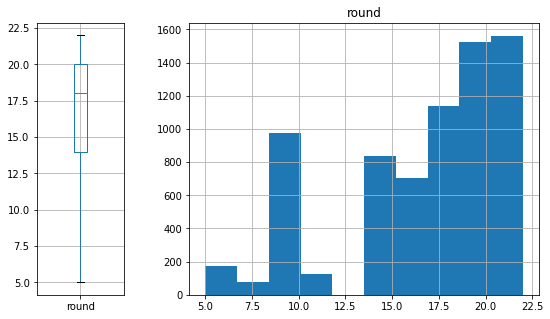

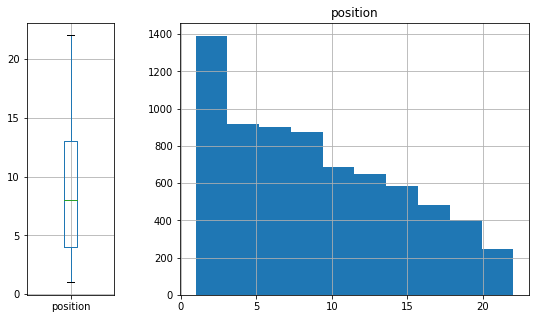

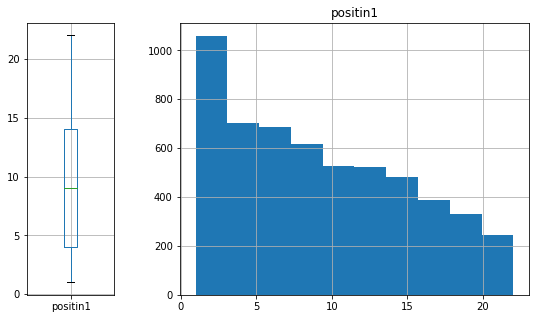

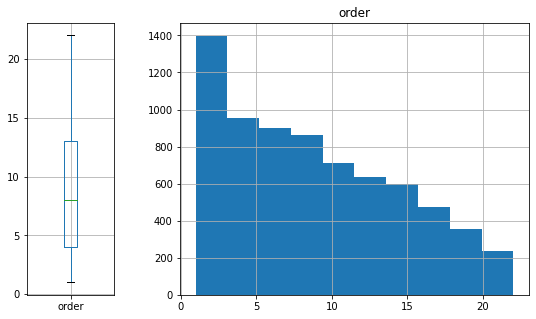

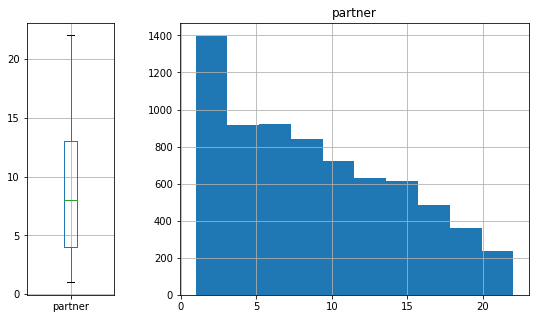

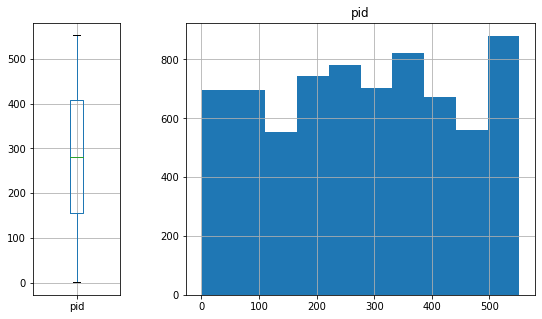

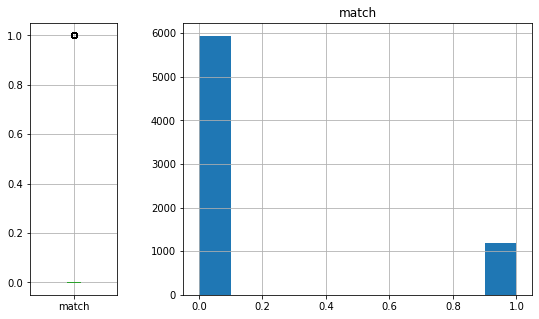

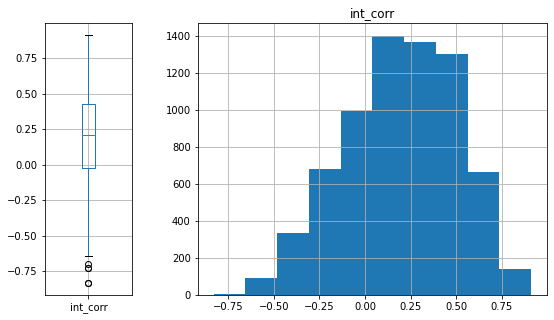

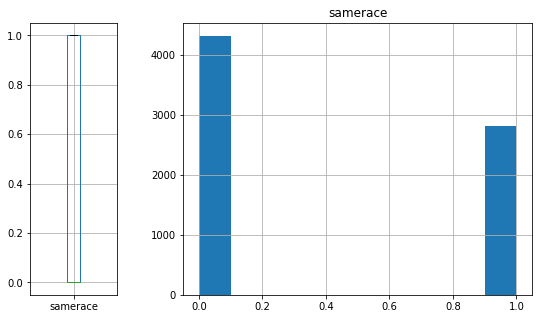

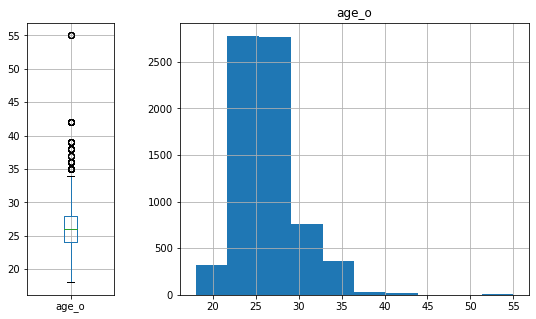

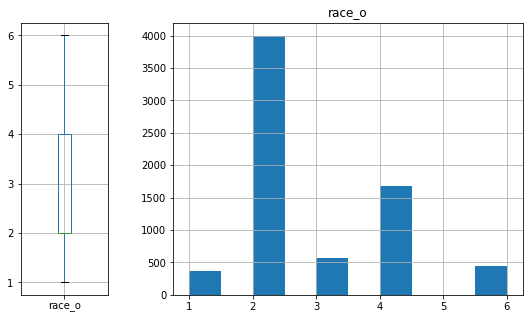

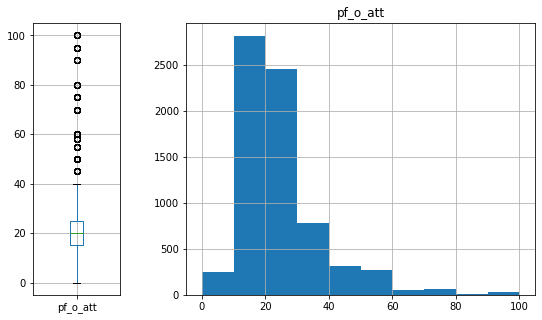

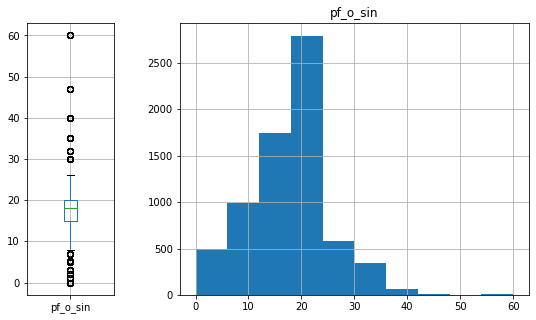

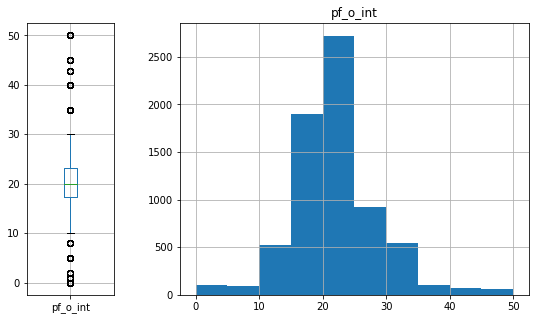

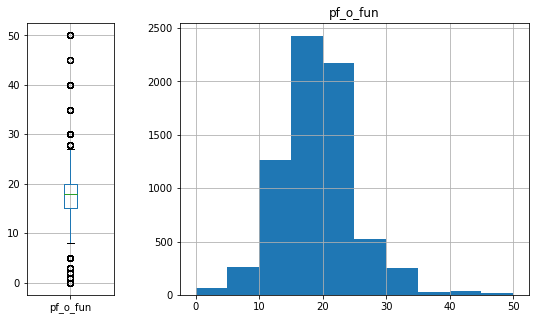

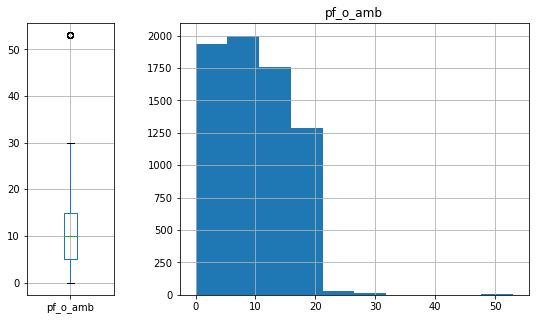

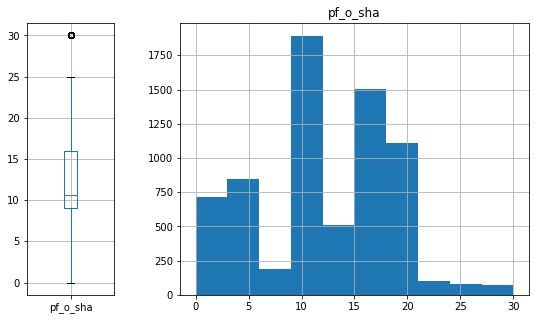

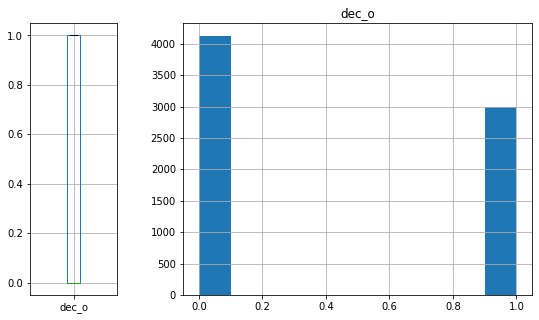

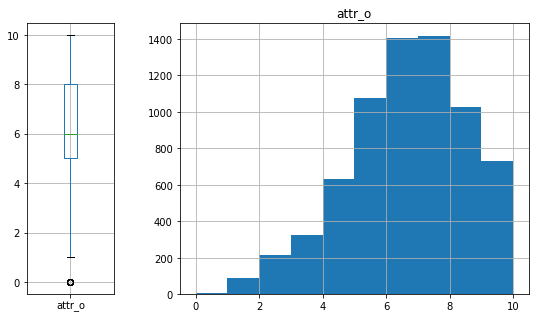

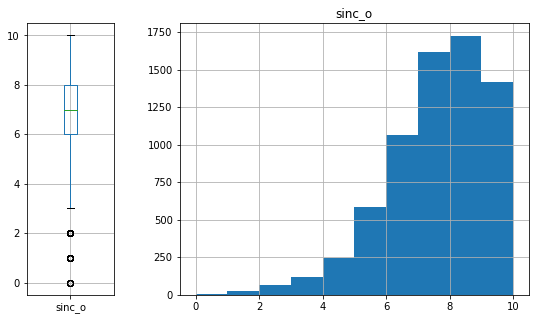

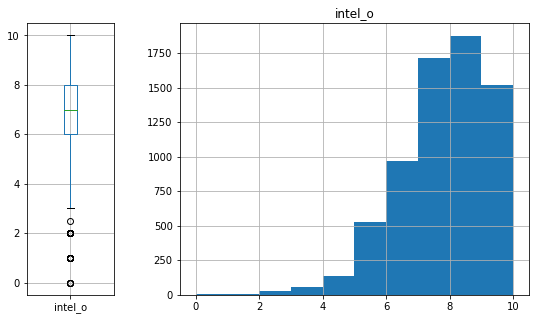

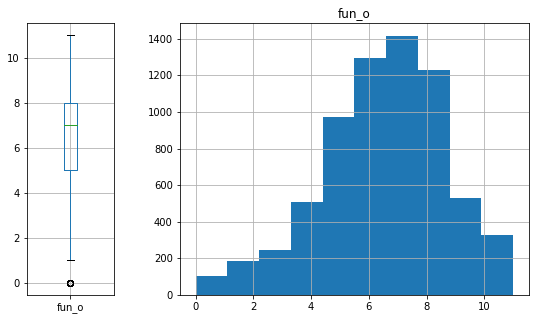

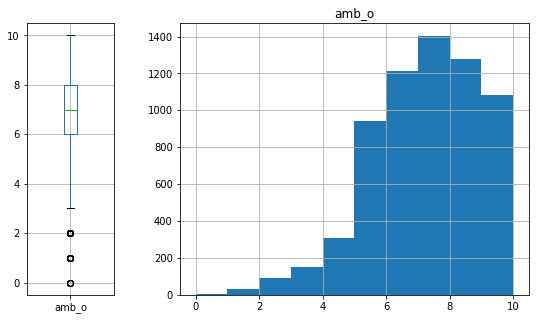

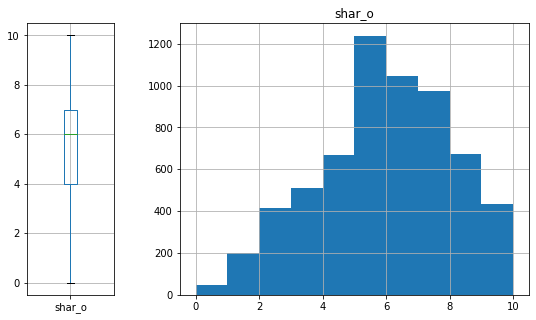

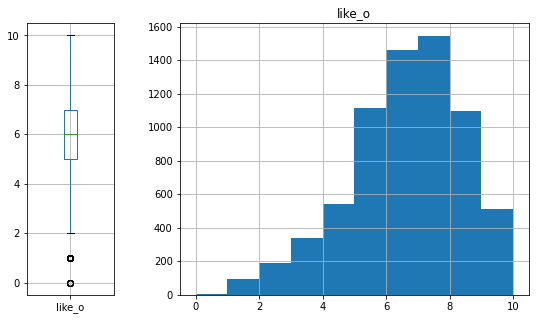

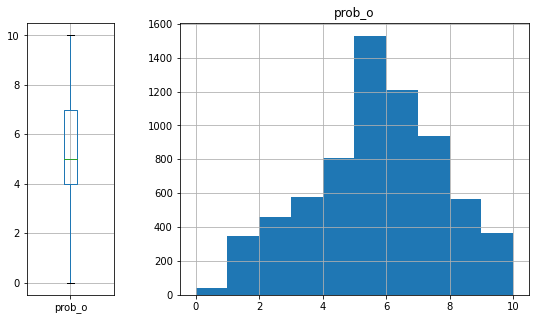

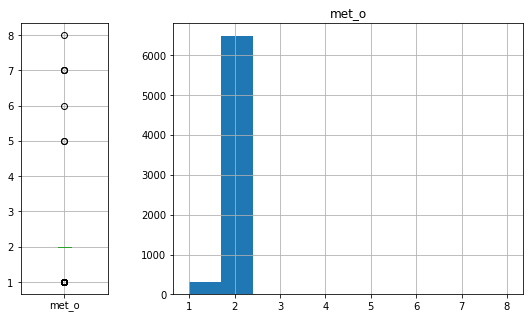

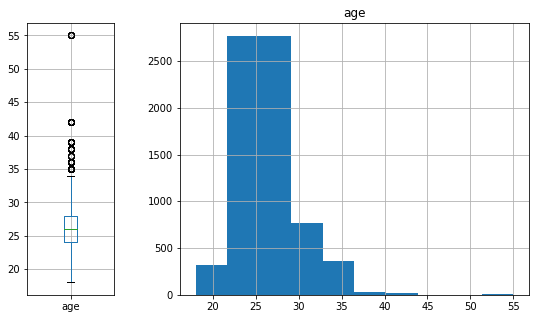

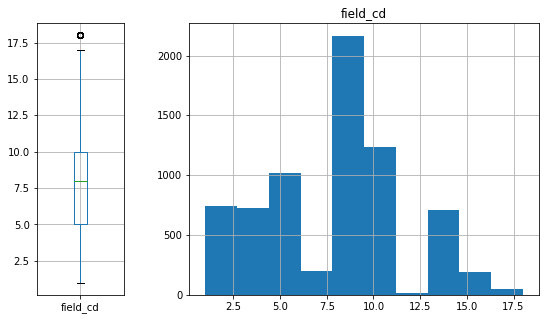

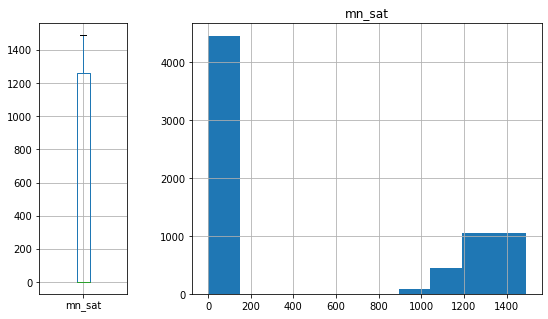

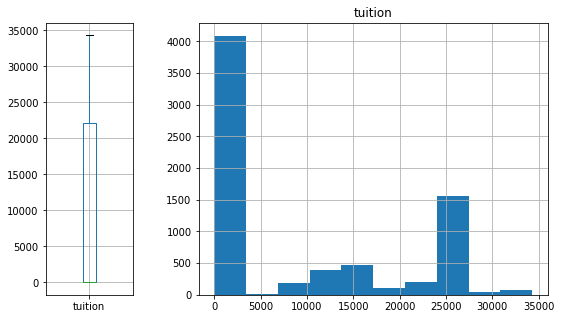

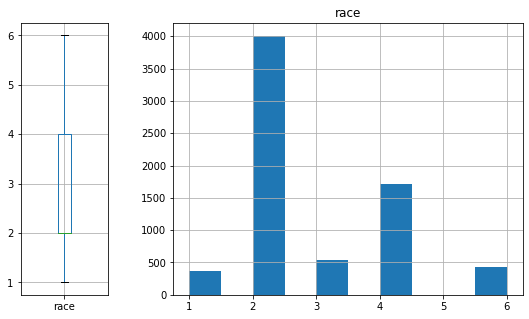

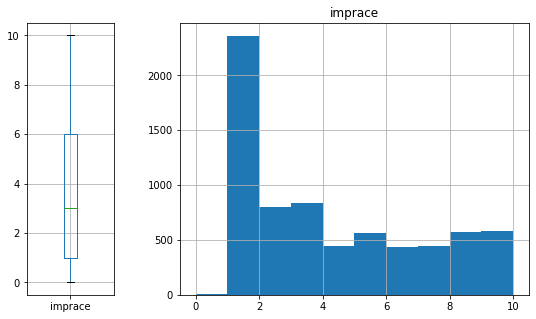

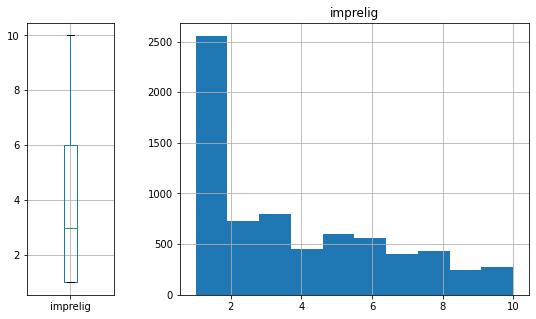

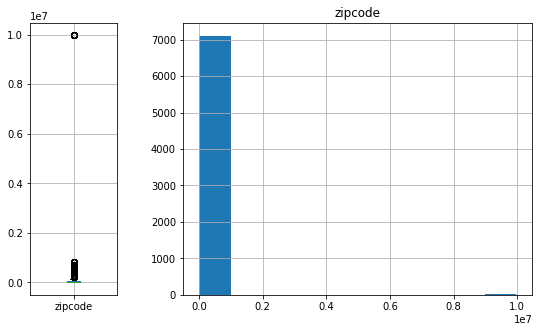

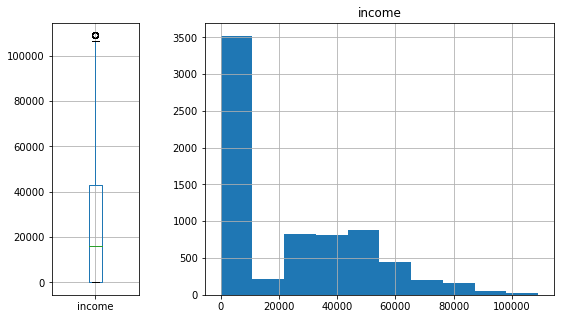

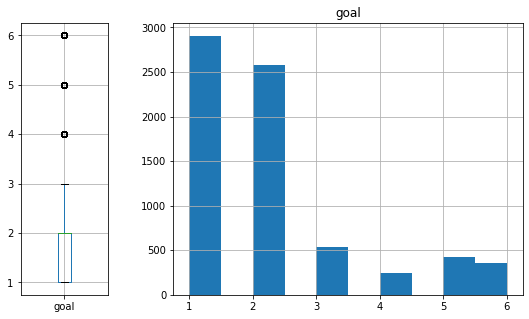

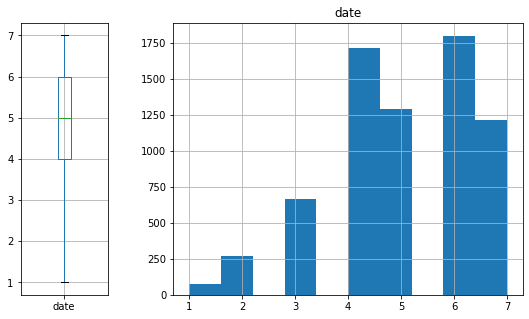

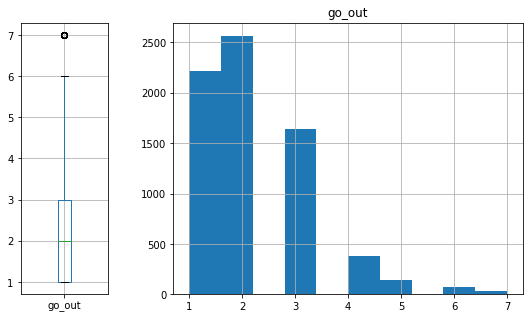

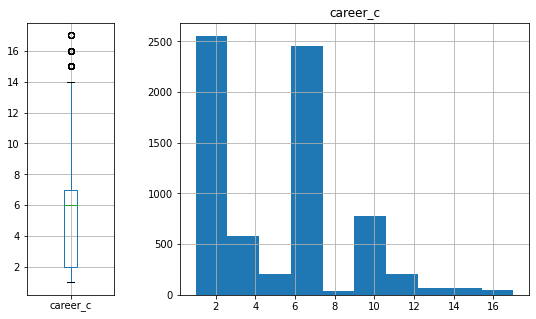

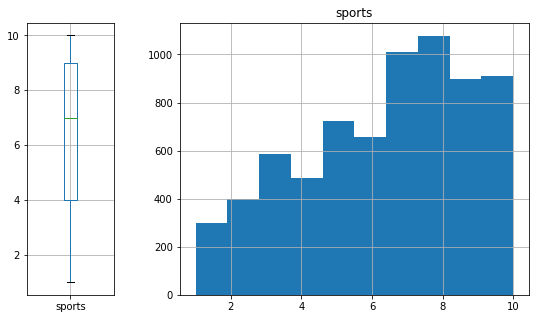

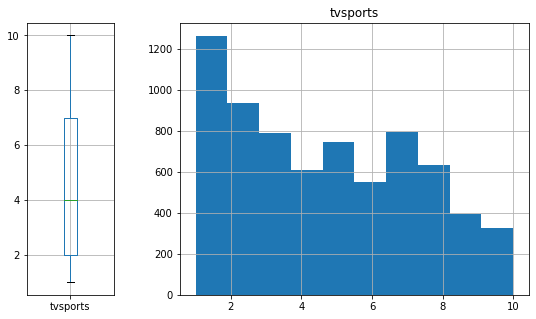

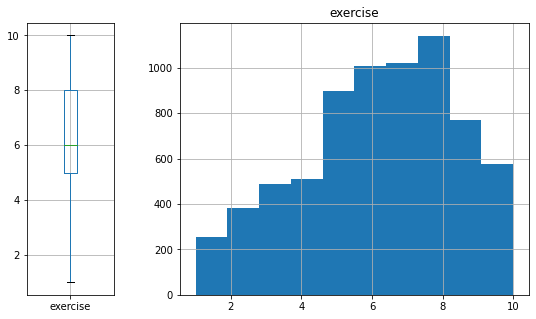

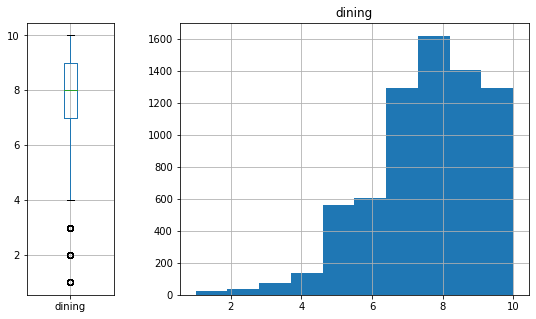

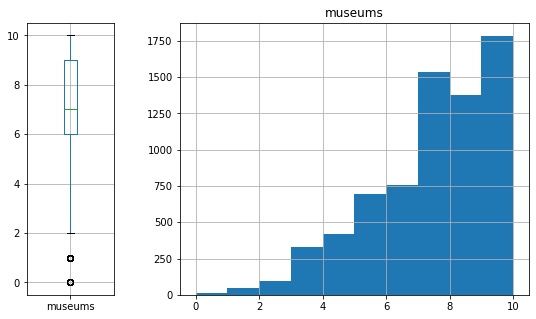

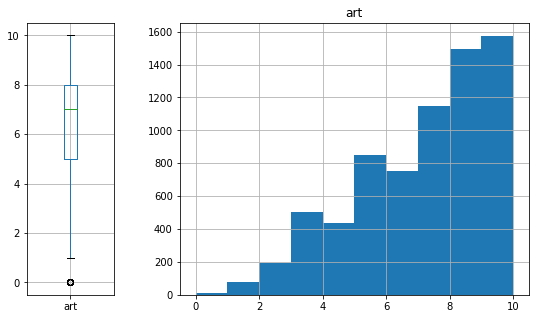

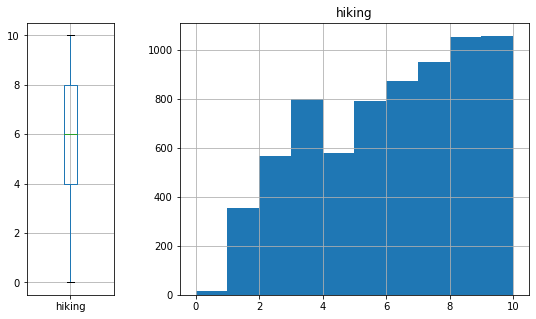

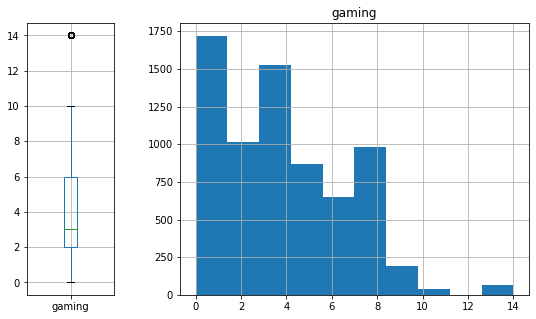

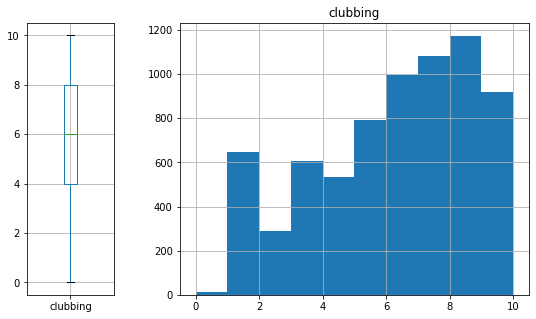

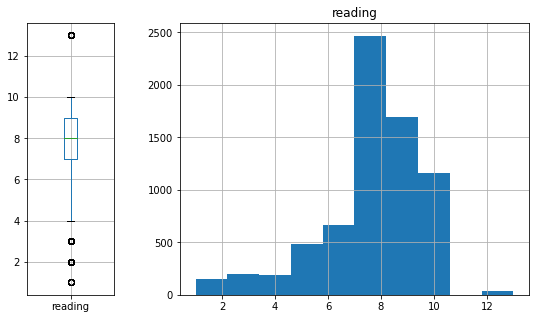

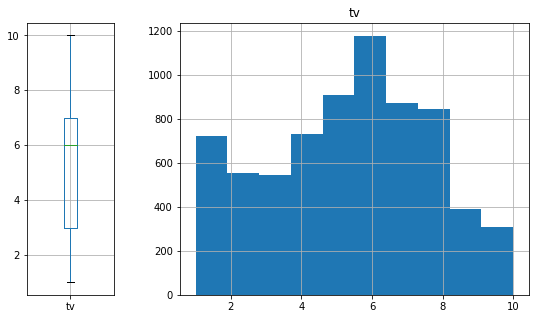

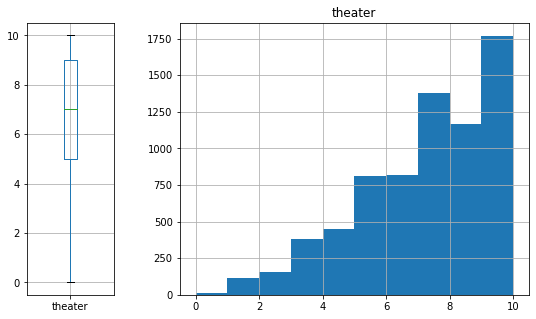

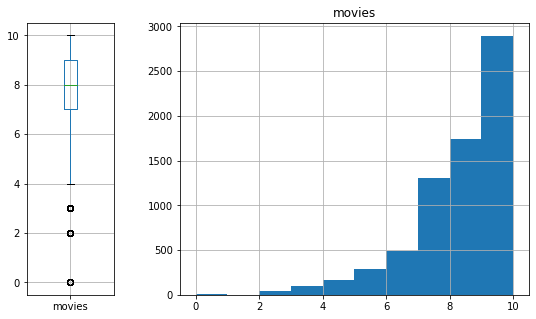

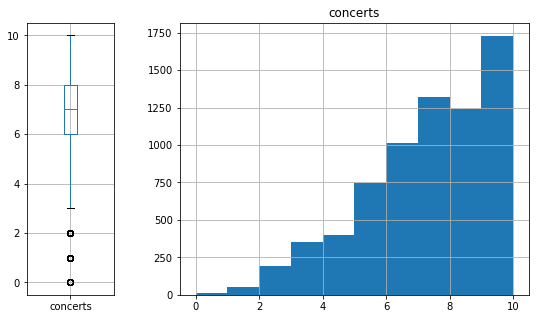

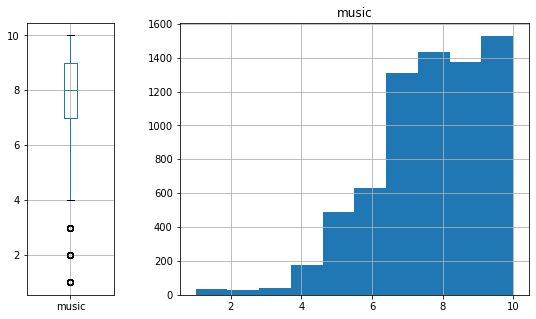

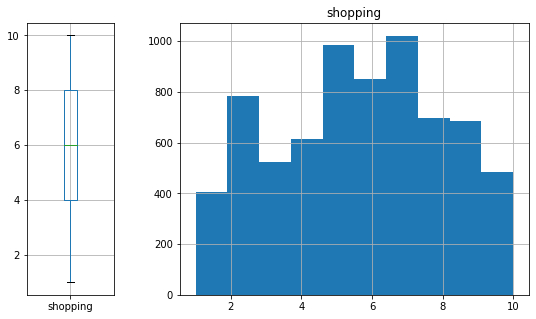

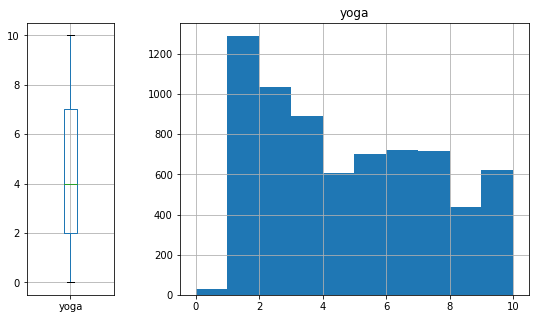

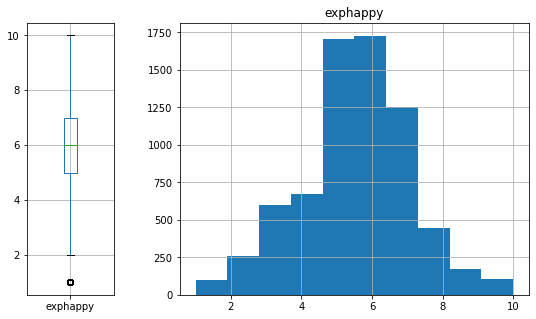

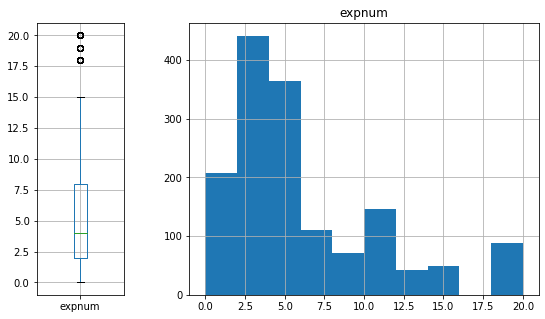

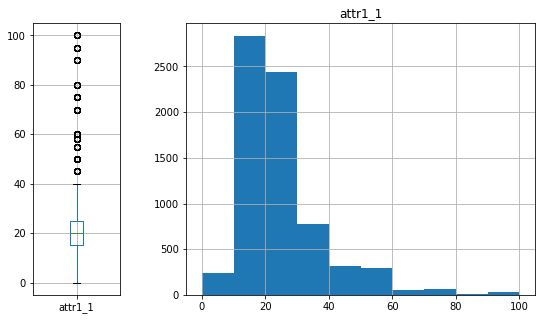

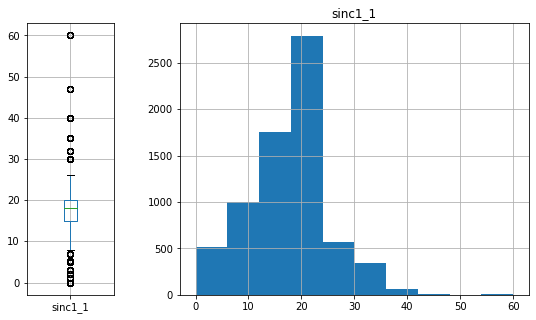

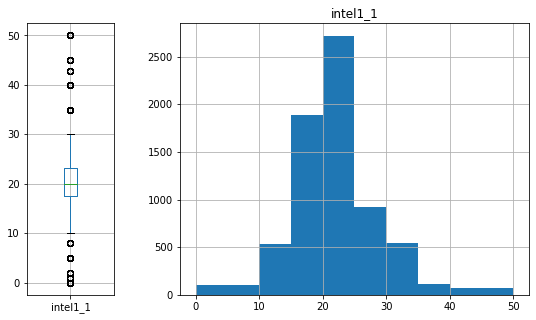

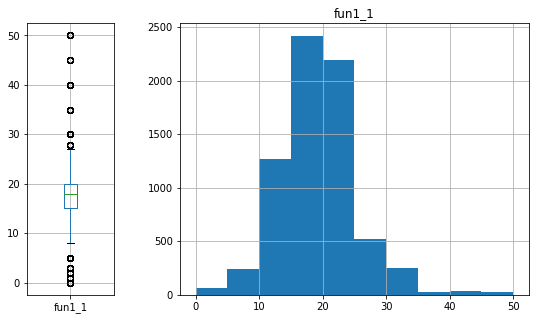

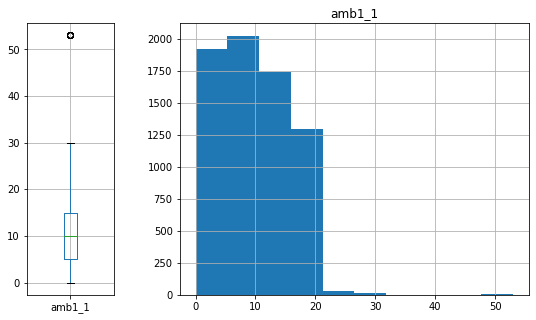

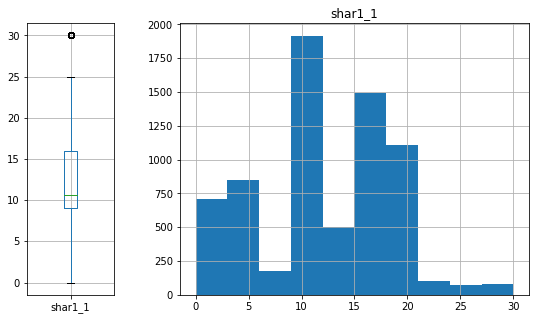

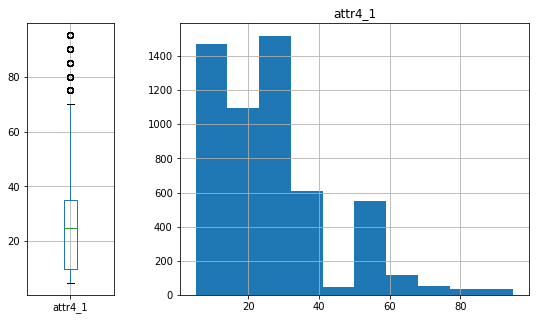

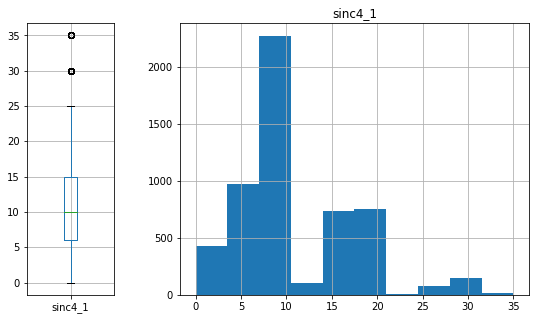

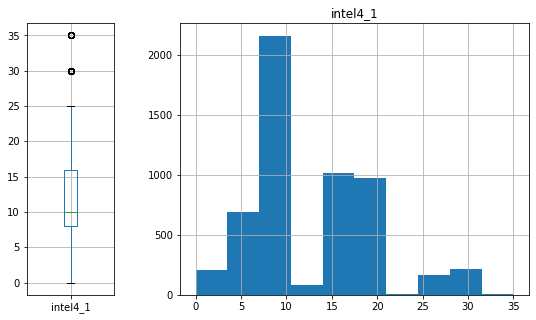

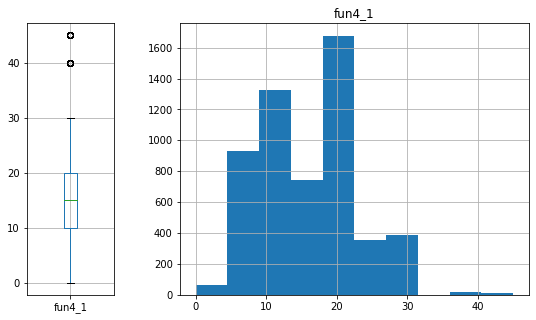

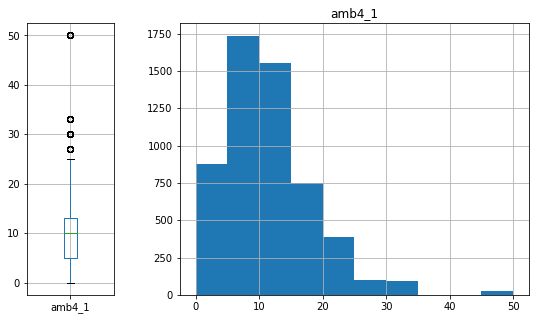

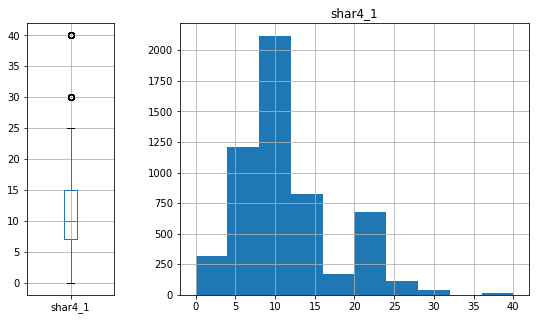

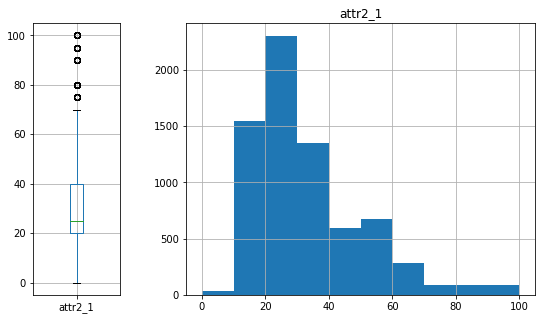

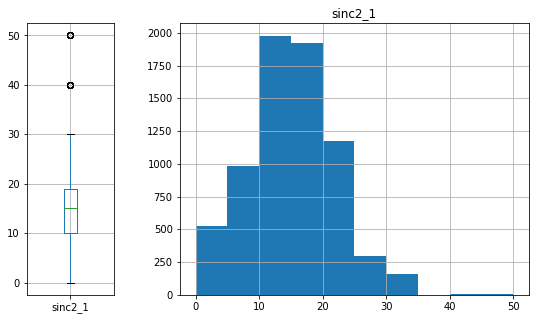

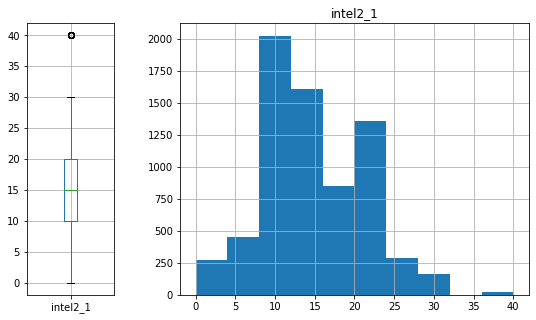

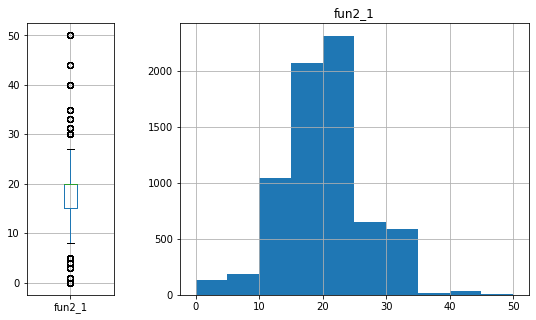

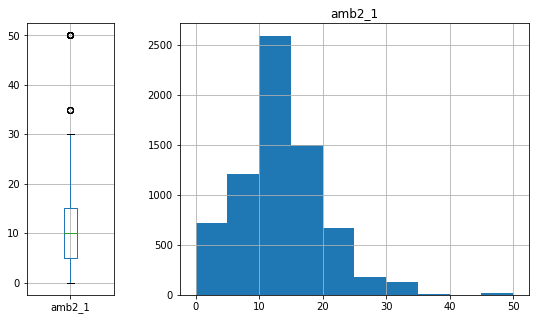

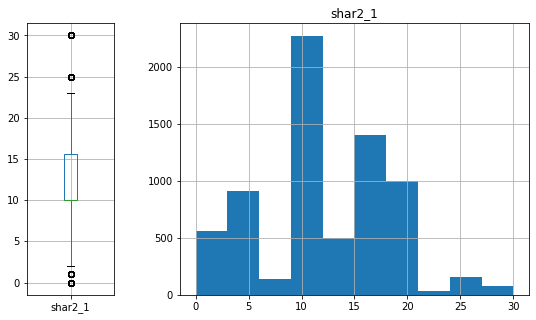

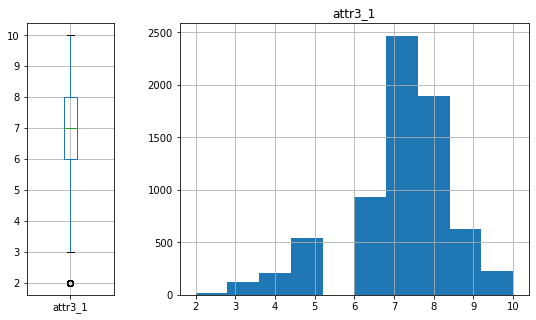

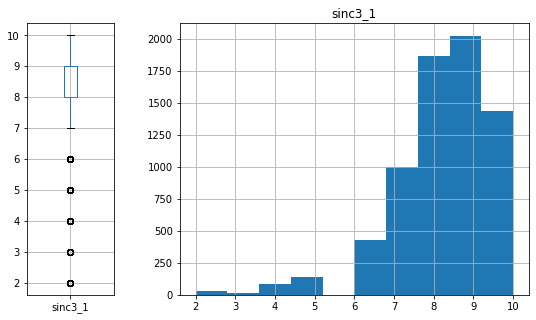

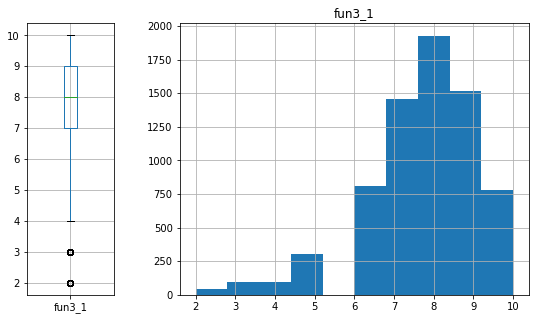

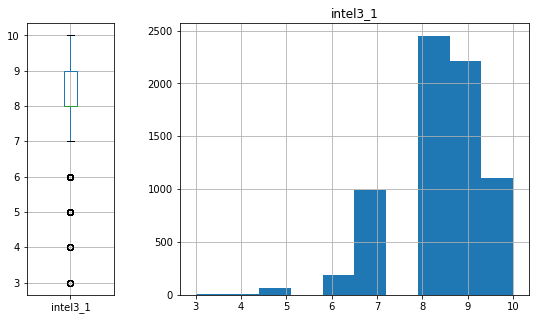

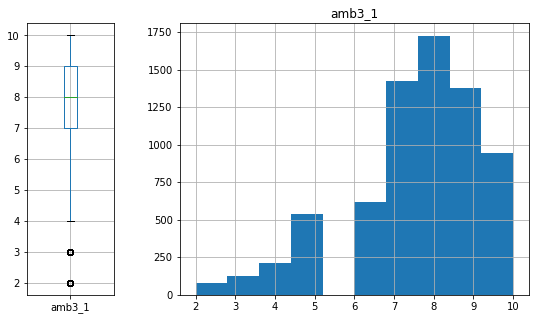

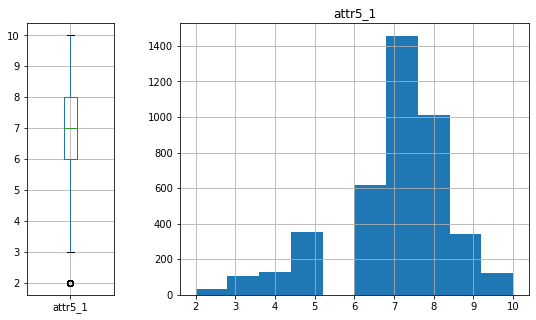

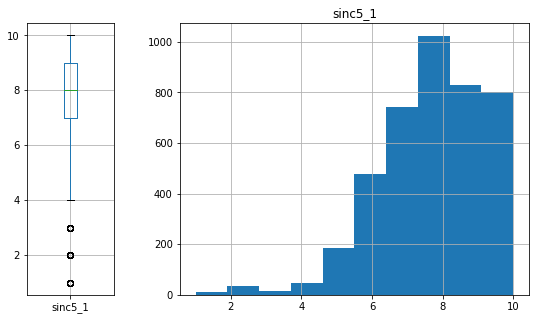

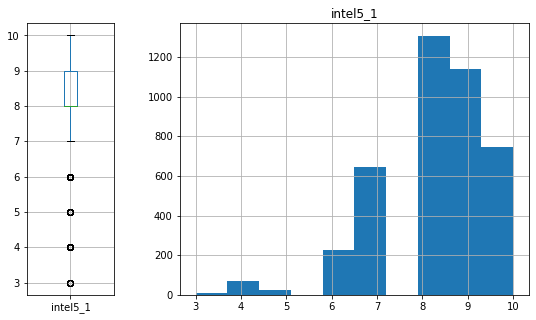

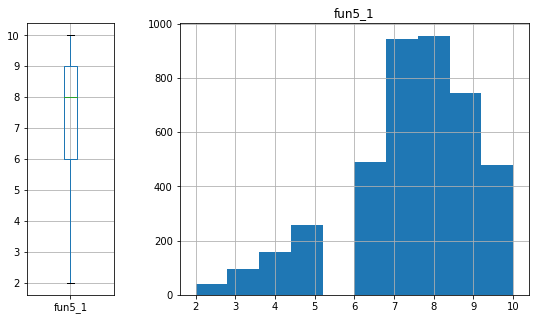

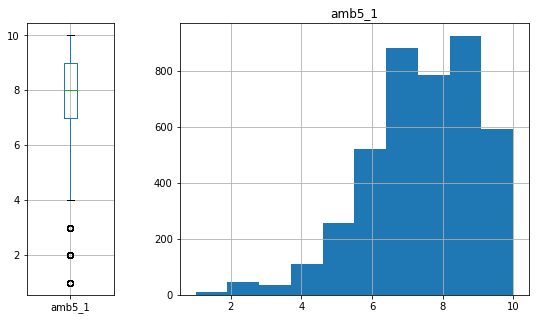

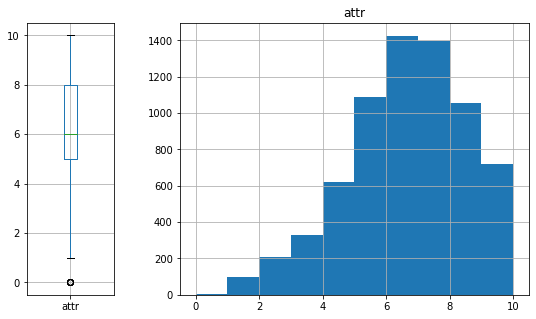

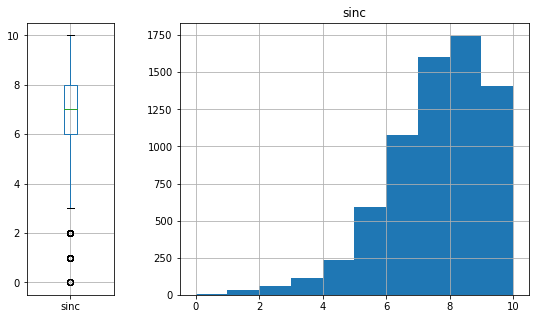

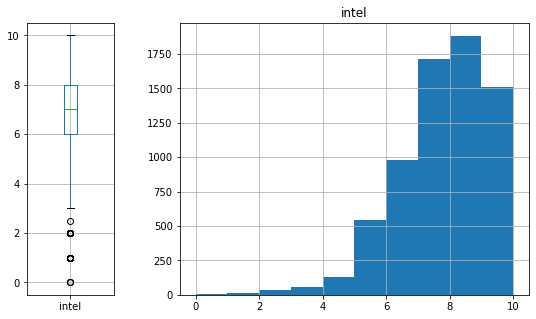

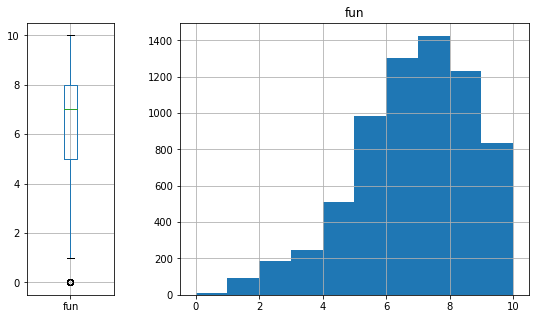

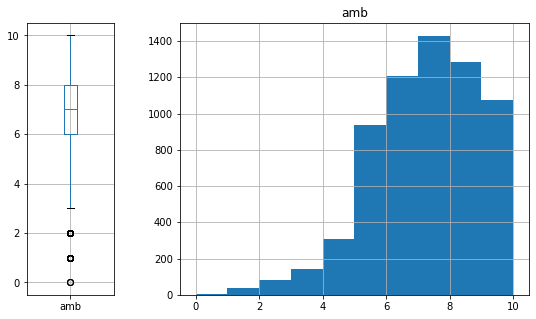

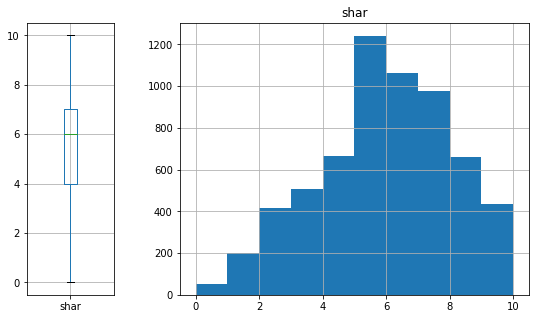

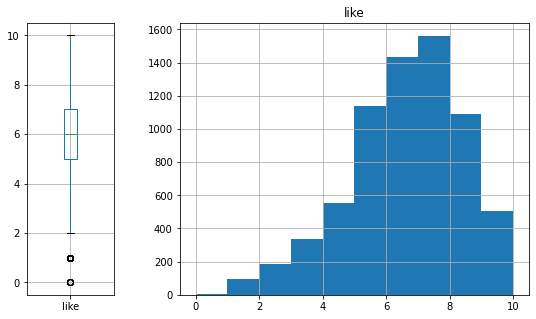

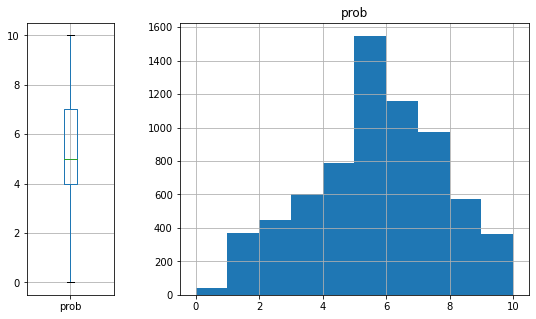

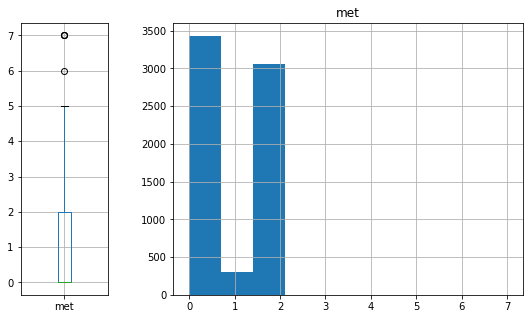

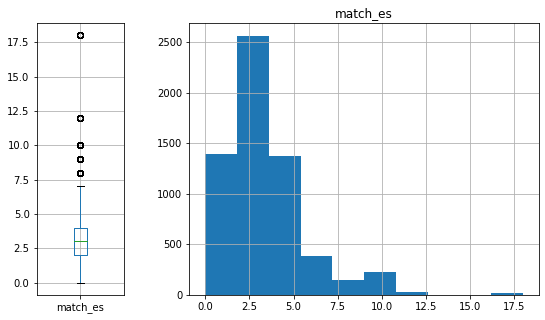

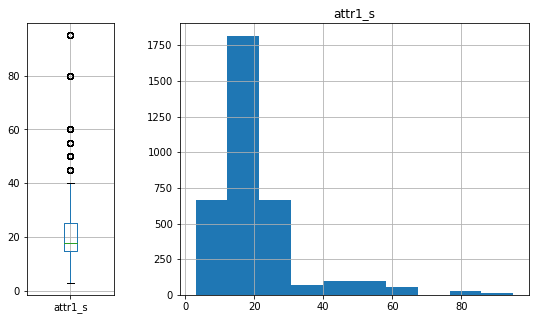

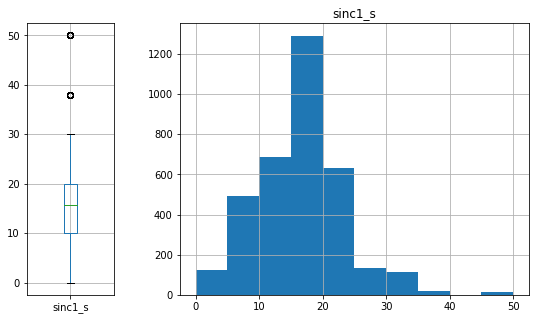

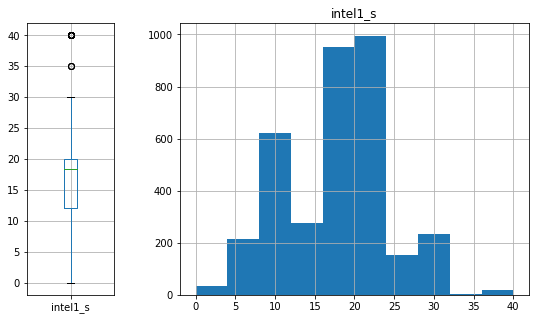

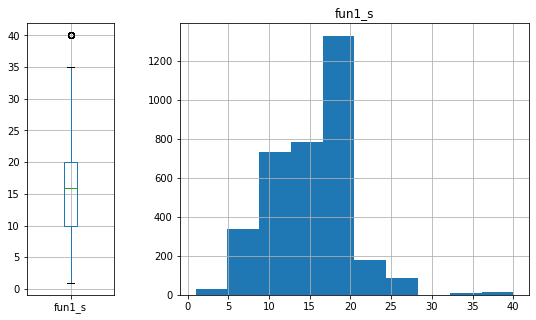

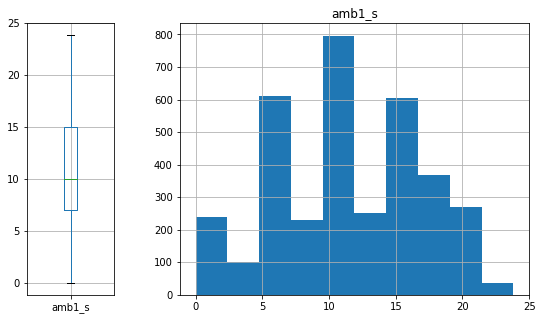

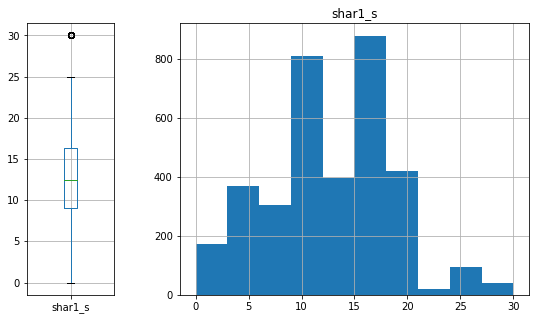

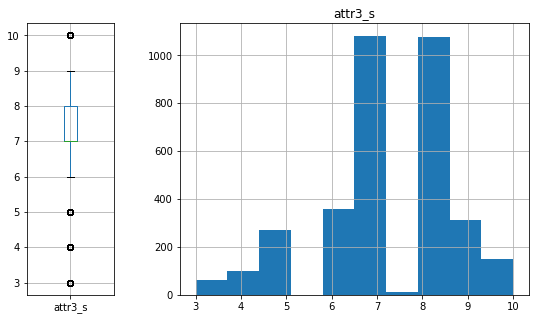

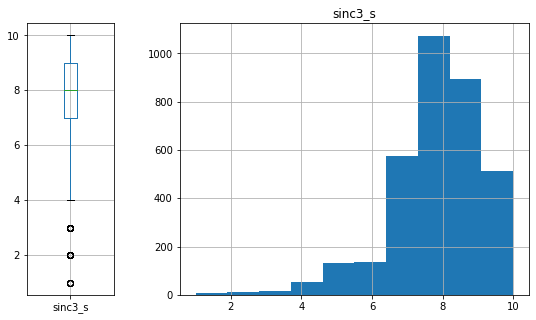

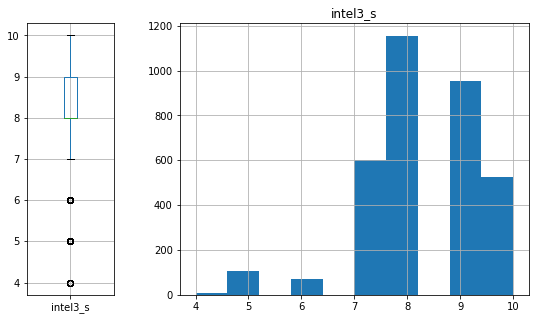

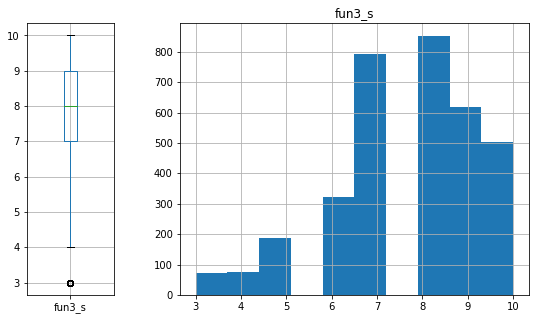

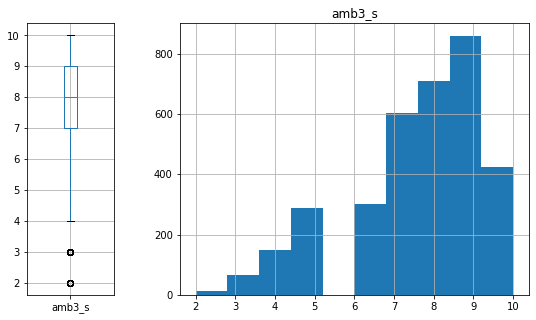

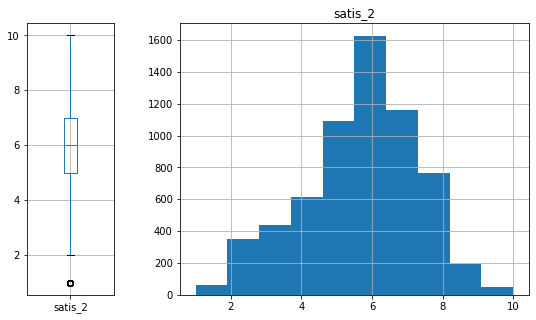

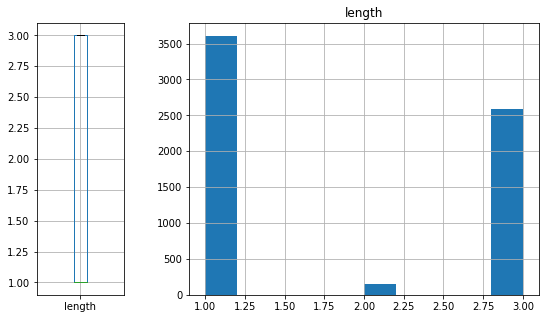

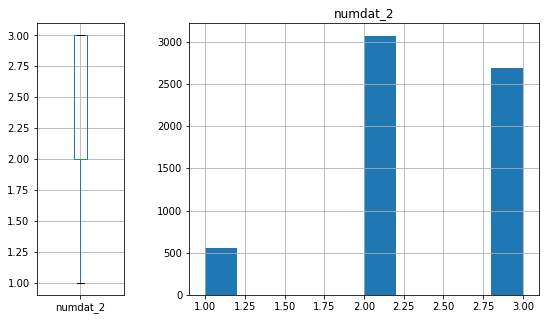

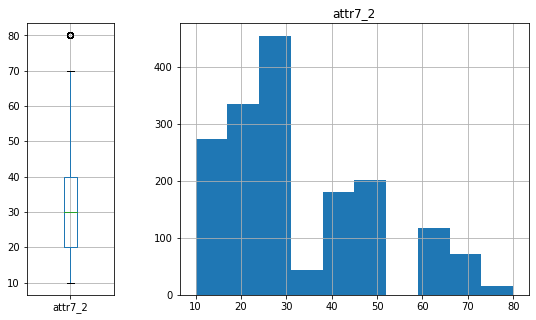

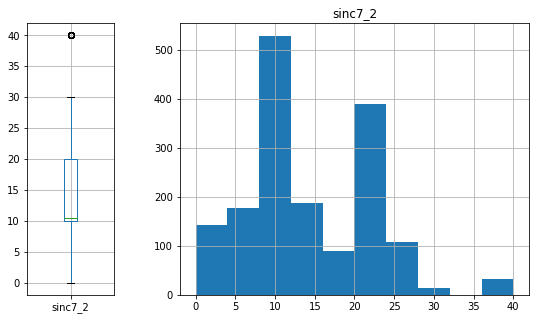

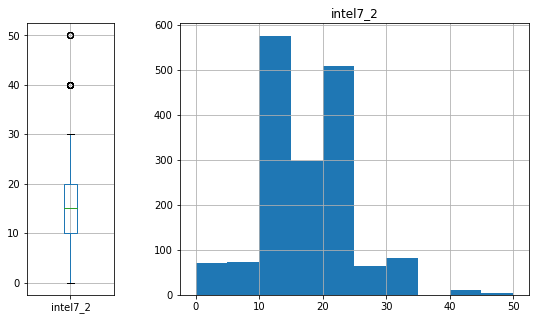

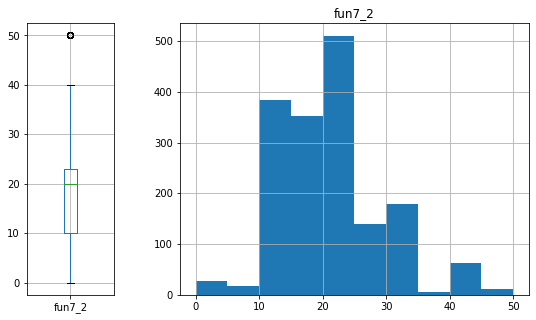

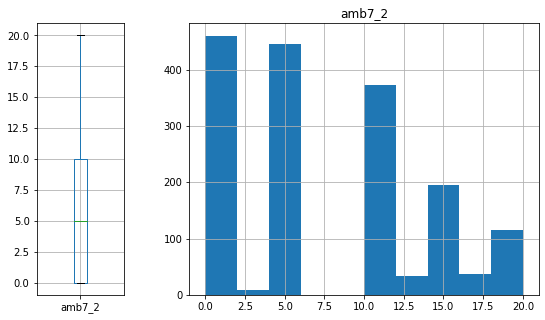

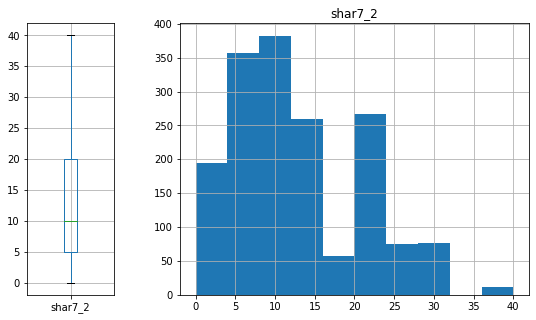

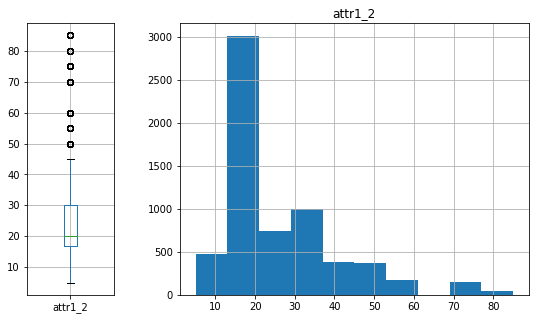

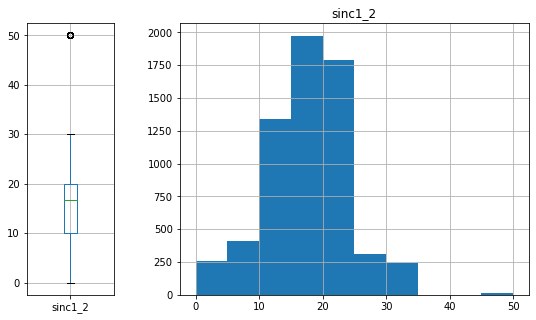

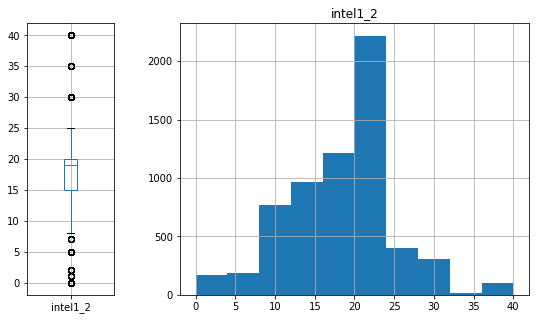

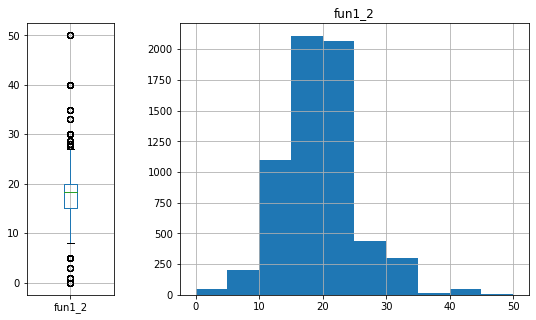

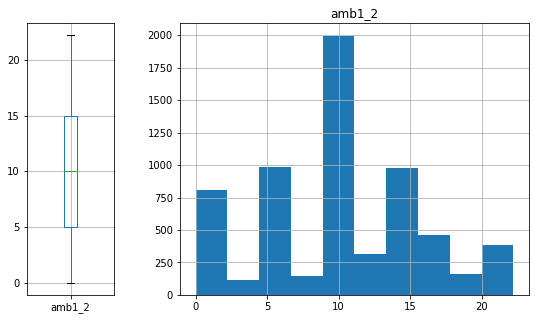

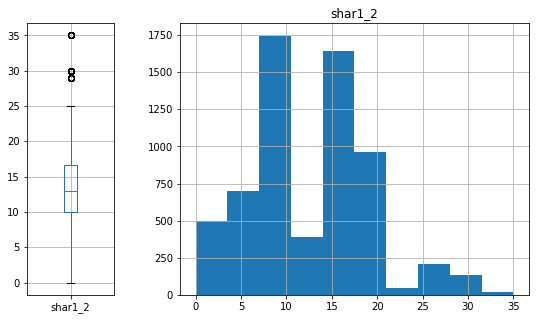

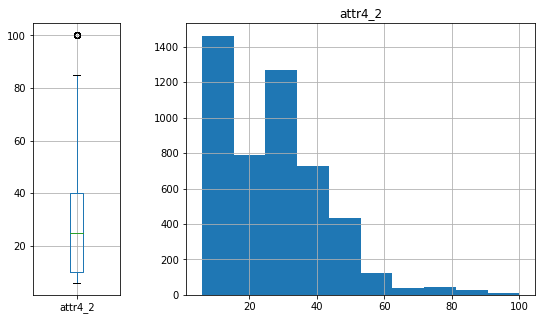

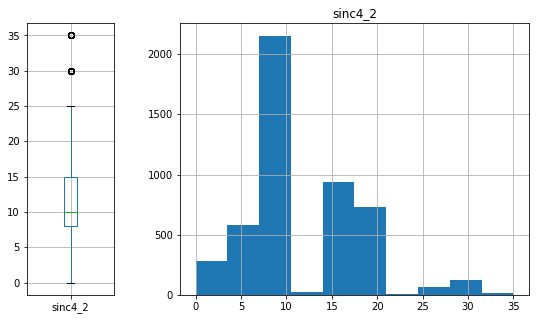

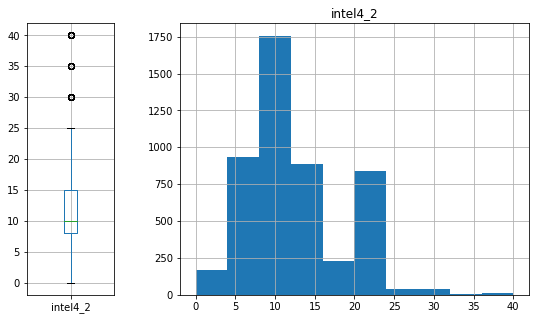

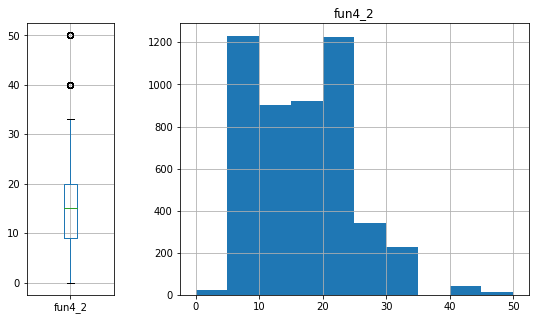

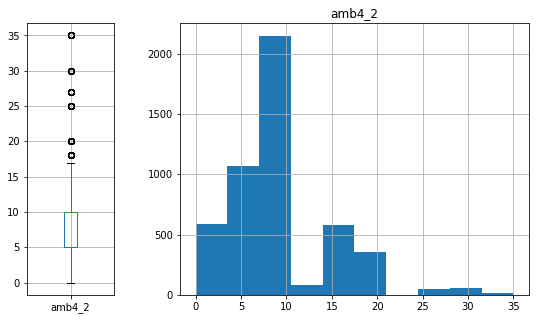

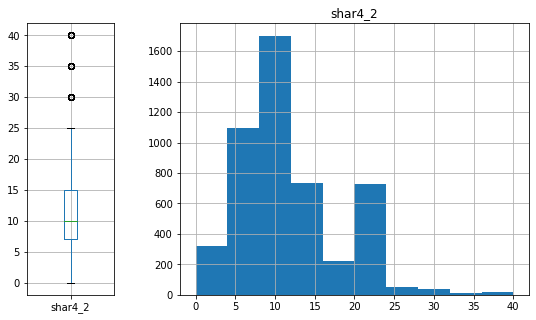

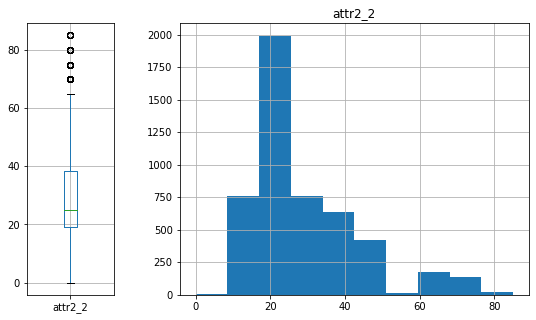

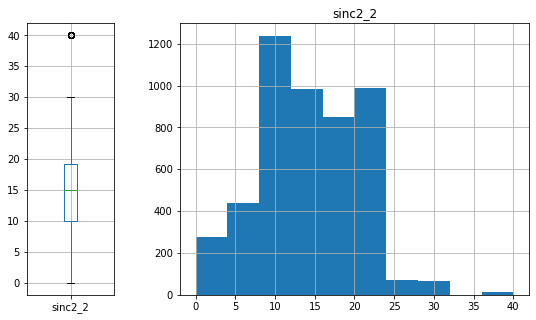

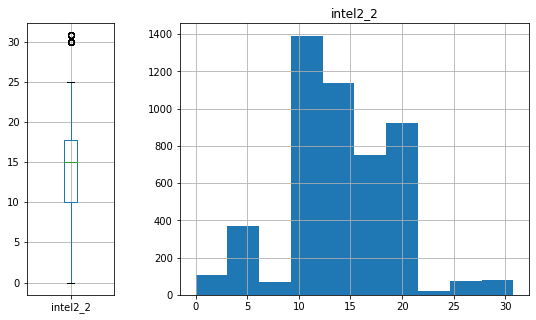

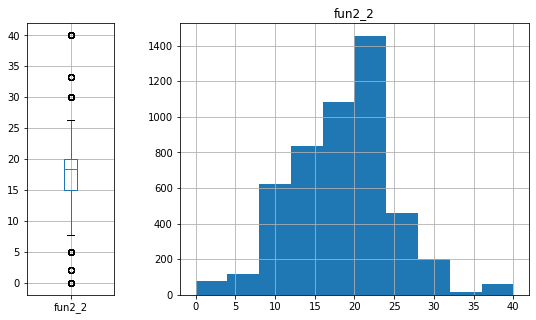

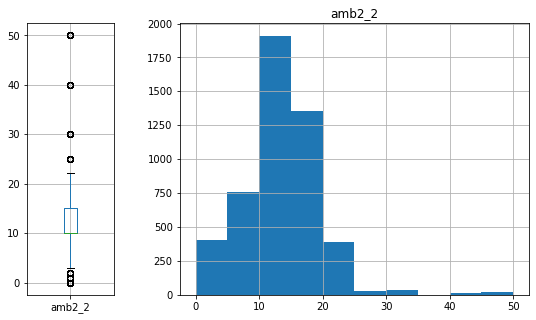

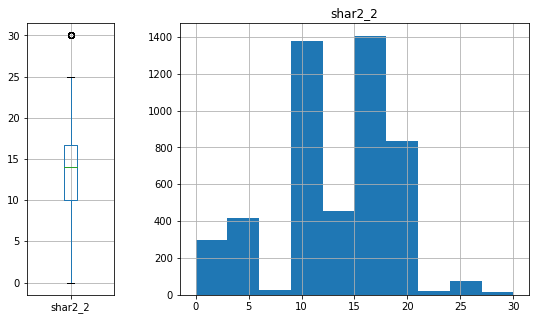

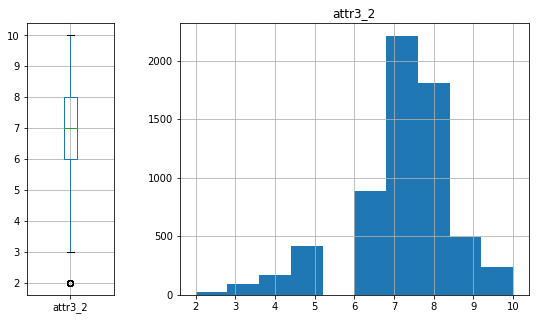

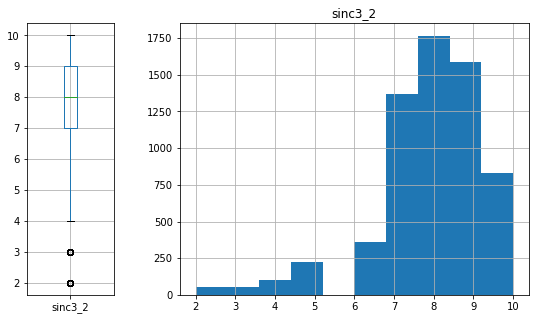

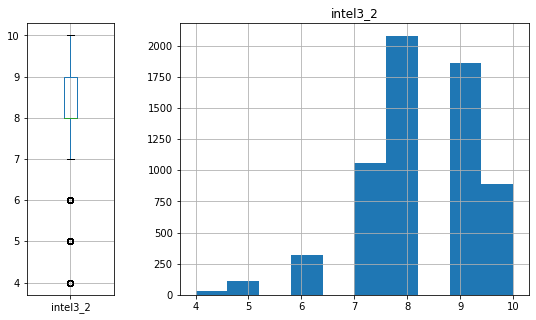

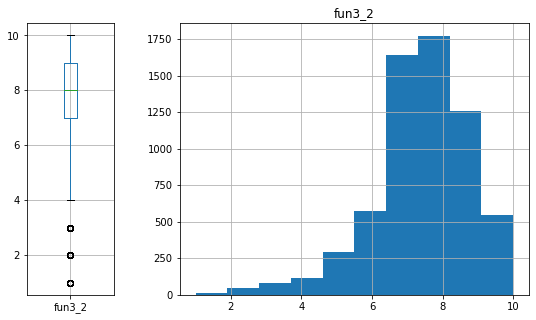

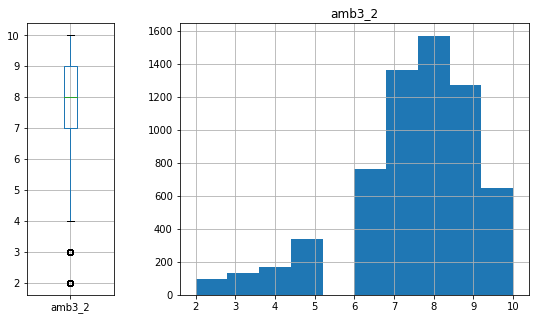

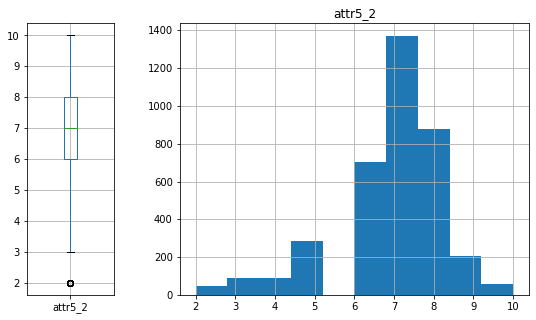

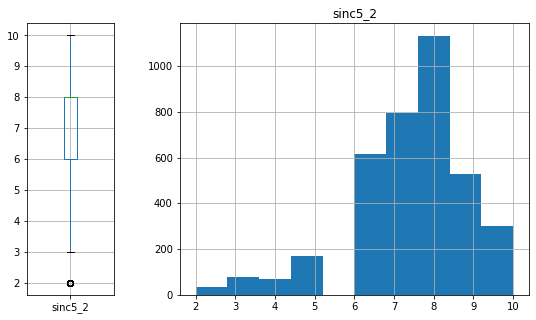

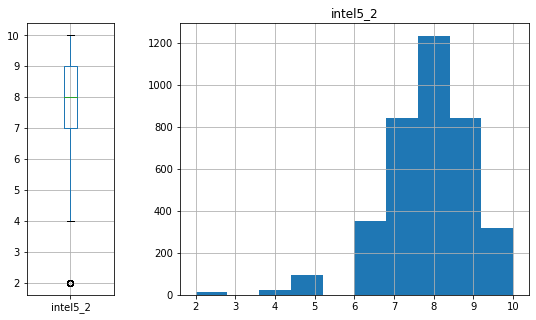

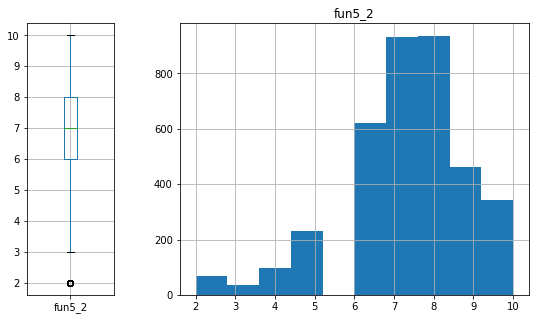

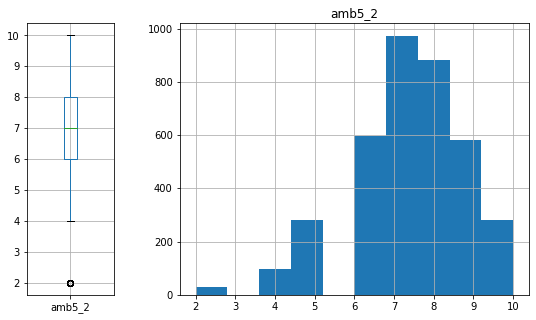

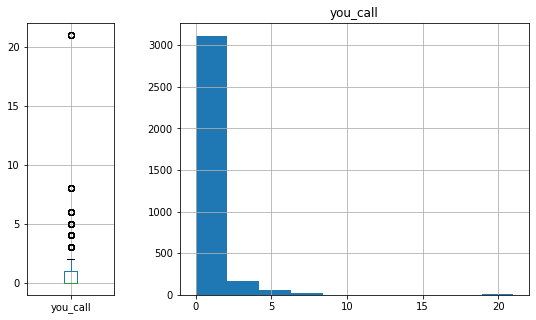

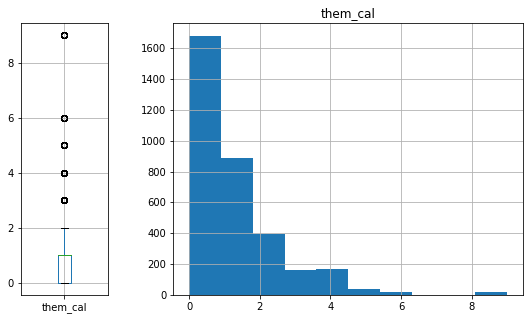

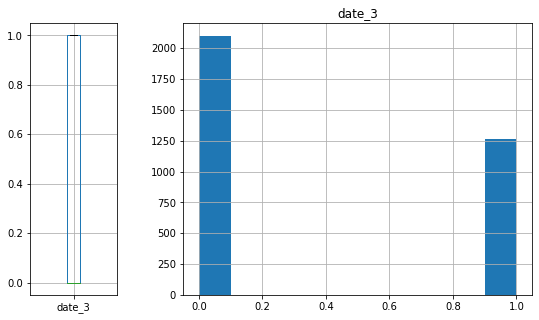

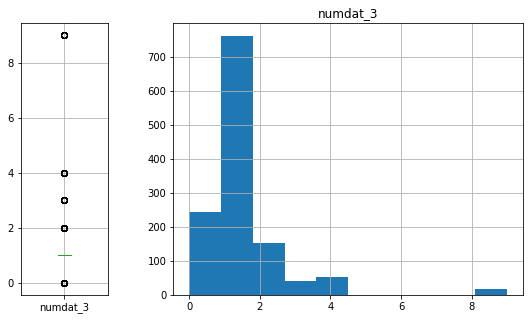

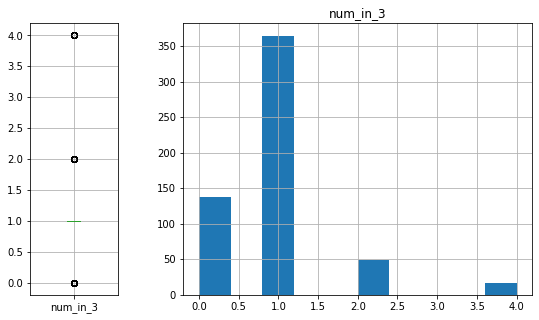

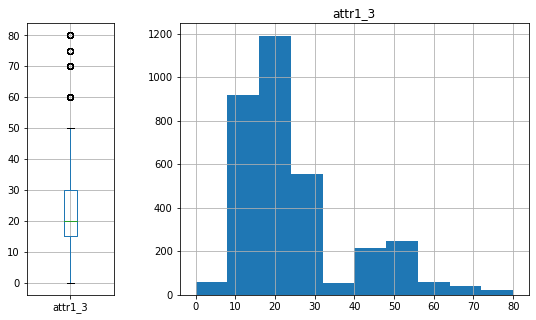

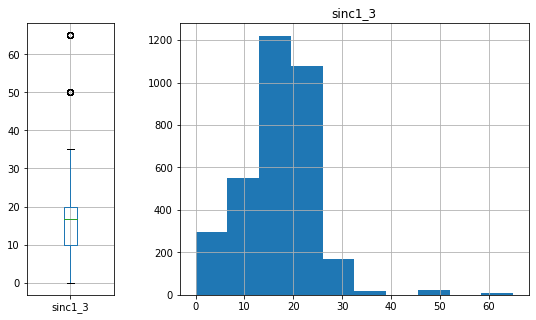

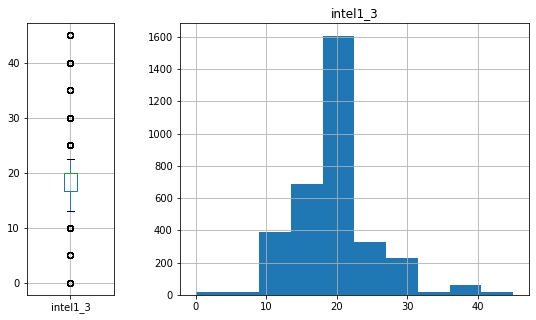

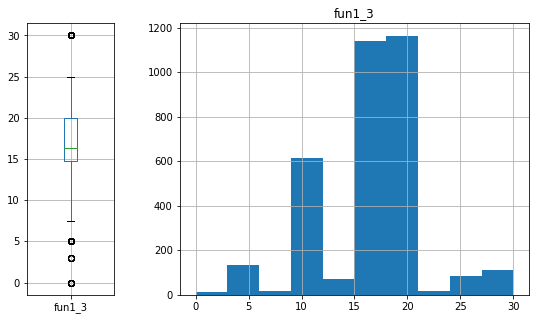

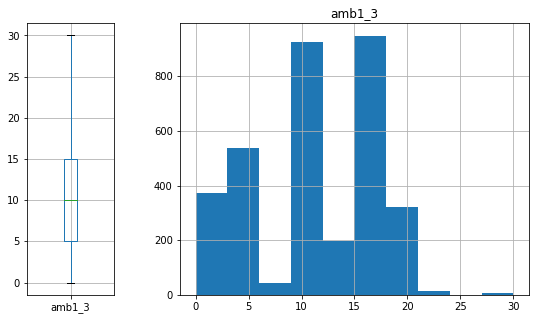

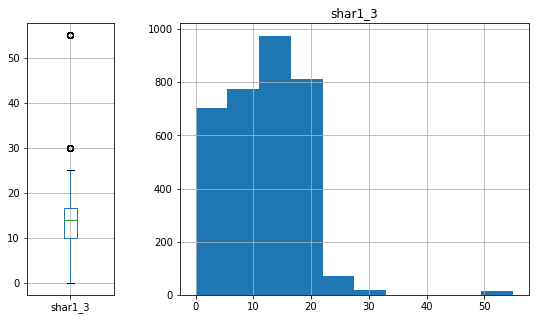

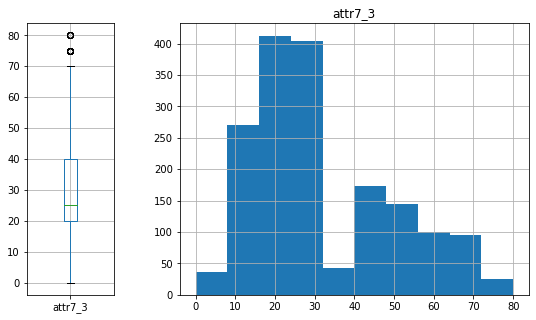

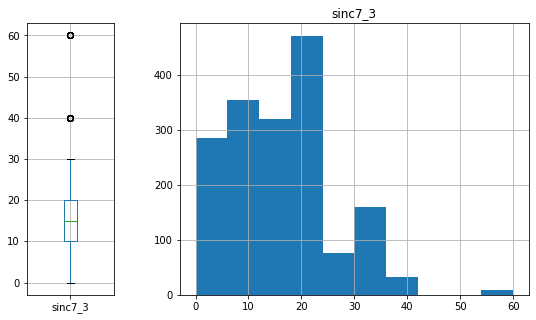

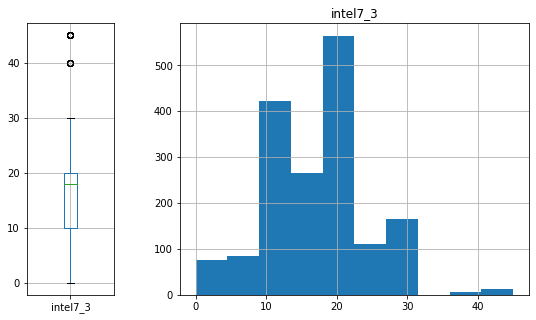

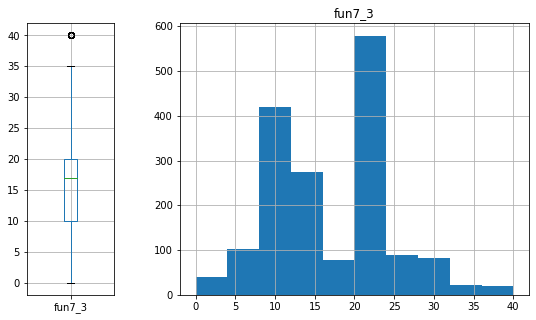

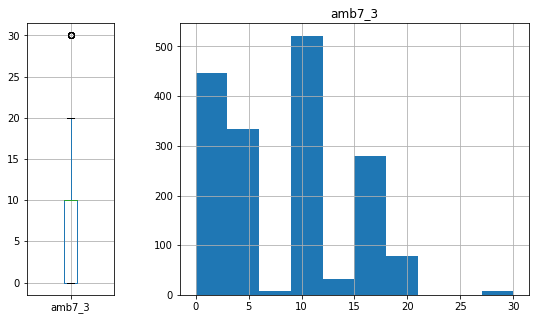

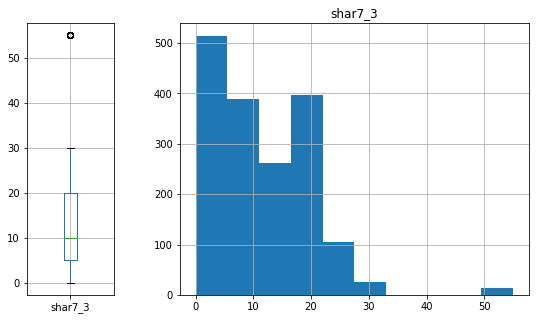

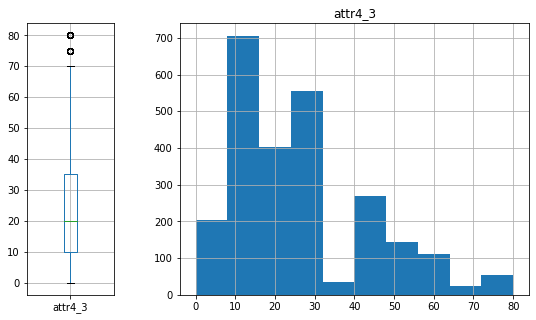

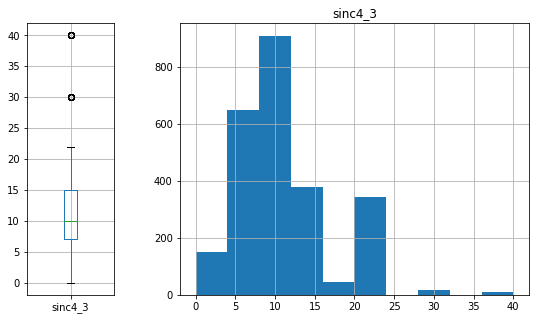

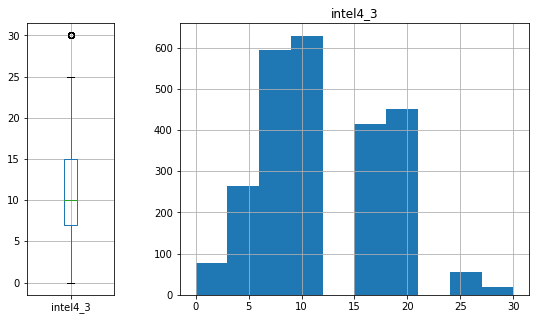

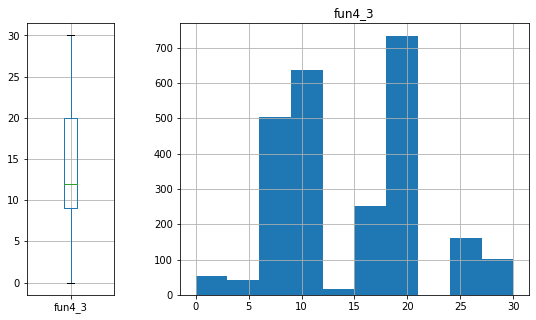

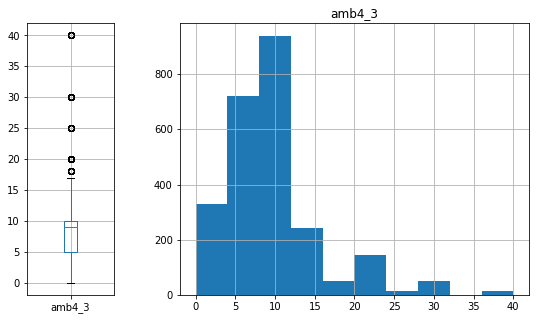

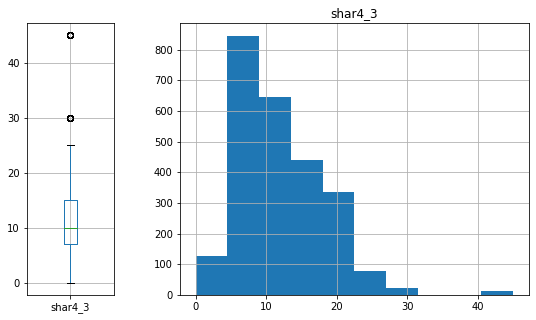

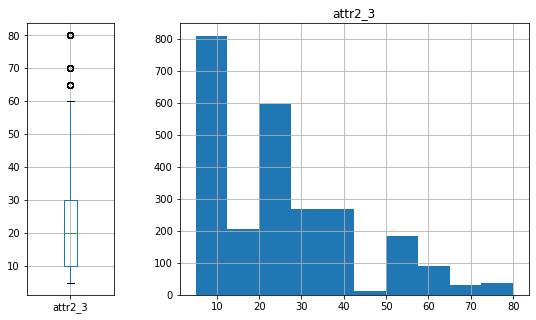

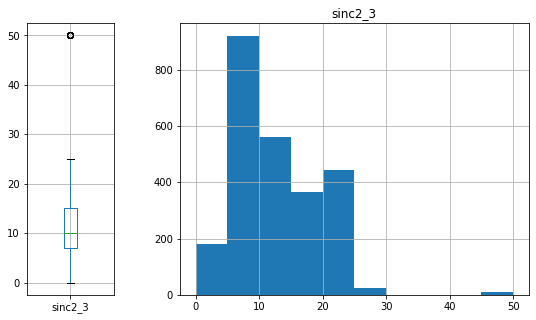

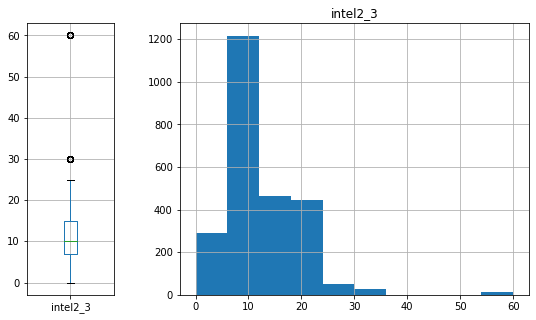

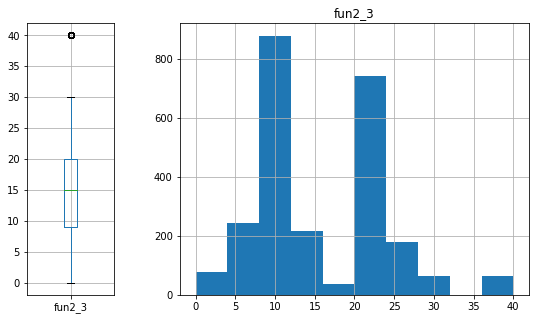

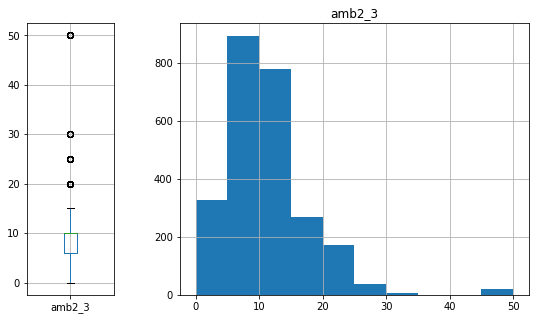

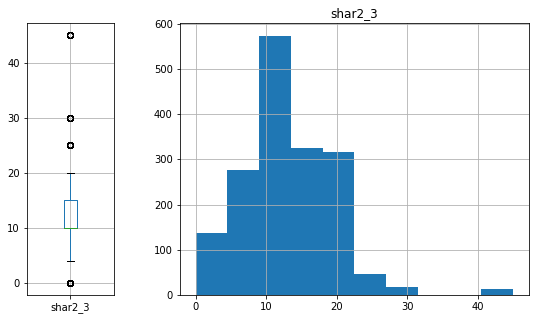

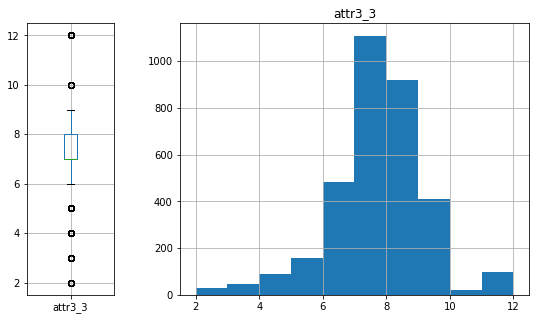

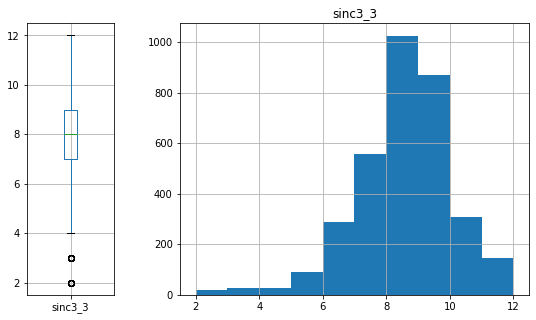

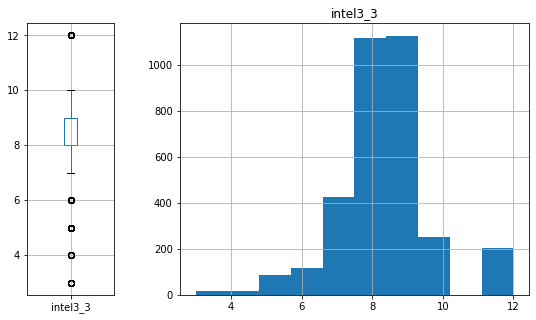

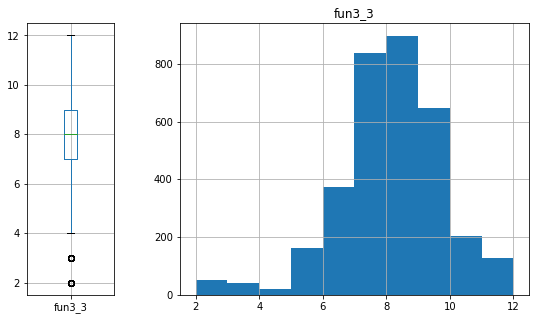

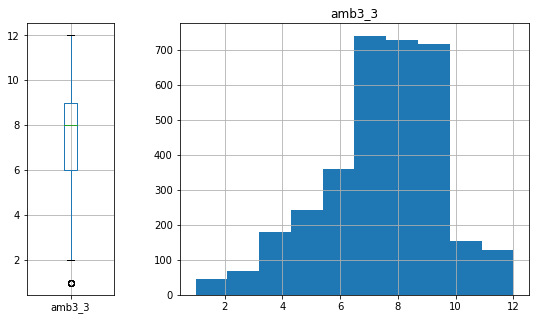

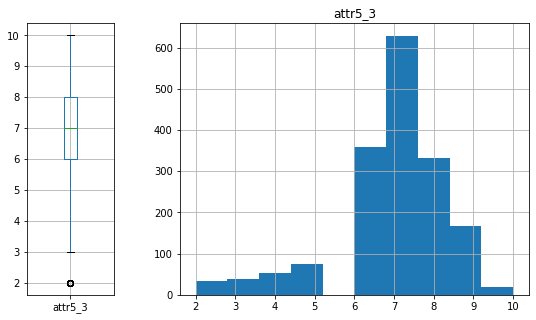

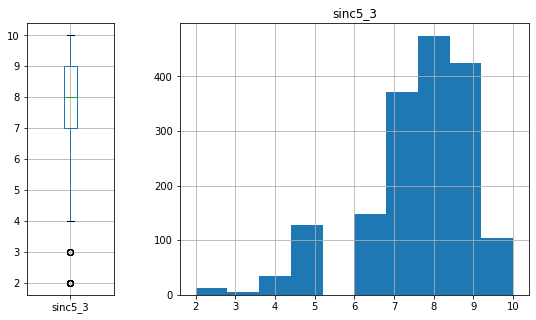

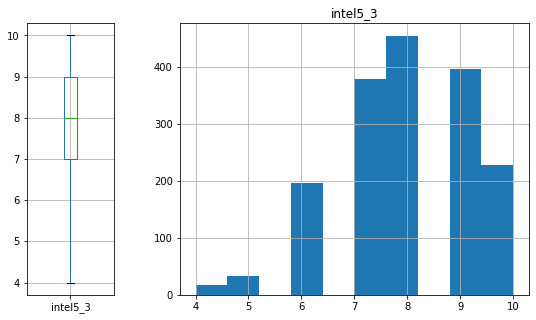

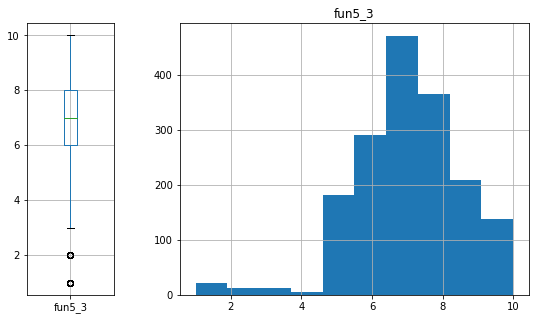

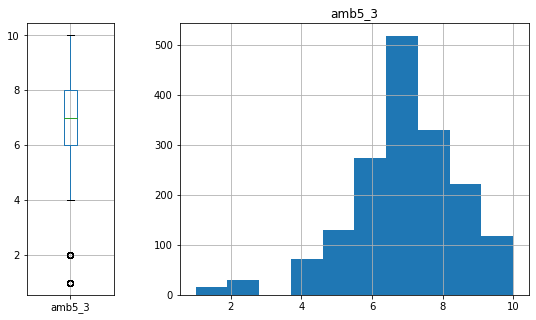

In [124]:
# get all numeric columns
train_numeric = train_df.select_dtypes(include="number")
train_numeric.shape
train_numeric.head()
total_num_cols = len(train_numeric.columns)
for col in train_numeric.columns:
    fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
    _ = train_df.boxplot(column=col,ax=axes[0]);
    _ = train_df.hist(column=col, ax=axes[1]);

In [125]:
def remove_outlier(df, col, times_std=3):
    """
    Basic way to remove outliers (via mean and std) 
    """
    upper_limit = df[col].mean() + times_std * df[col].std()
    lower_limit = df[col].mean() - times_std * df[col].std()
    df[col] = np.where(
        df[col] > upper_limit,
        upper_limit,
        np.where(
            df[col] < lower_limit,
            lower_limit,
            df[col]
        )
    )
    return df

Below mentioned are the articles, blogs, papers and other resources which we took inspiration from or we think are useful for future use case

#### References

- [_Getting Started with Data Preprocessing in Python_](https://www.section.io/engineering-education/data-preprocessing-python/)
- [_Data Preprocessing in Python_](https://medium.datadriveninvestor.com/data-preprocessing-3cd01eefd438)
- [_Data Pre-processing in Python for Beginner_](https://medium.com/data-science-indo/data-preparation-in-python-for-beginner-d3e1e60c03a6)
- [_Data Preprocessing using Python_](https://medium.com/@suneet.bhopal/data-preprocessing-using-python-1bfee9268fb3)
- [_Data preprocessing for Machine Learning in Python_](https://towardsdatascience.com/data-preprocessing-for-machine-learning-in-python-2d465f83f18c)
- [_Data Preprocessing in Machine Learning_](https://www.analytixlabs.co.in/blog/data-preprocessing-in-machine-learning/)
- [_Normalization vs Standardization — Quantitative analysis_](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)
- [__]()
- [__]()
- [__]()
- [__]()
- [__]()
- [__]()